# GBA1 Hit Validation: Proteome-wide Ranking

This notebook evaluates GBA1 hits by performing link prediction between each small molecule and every protein in the human proteome using the PROTON model. We determine the rank of GBA1 among all possible protein targets to assess specificity/sensitivity.

### Objectives
1. Load PROTON model and pre-trained embeddings.
2. Load new embeddings for GBA1 hits (generated previously).
3. Score each GBA1 hit against ~20,000 proteins.
4. Calculate the rank of GBA1 for each hit.
5. Visualize the rank distribution.

In [1]:
import logging
import os
import sys
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from rdkit import Chem

# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
_logger = logging.getLogger(__name__)

# --- Path Setup ---
def _find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for parent in (start, *start.parents):
        if (parent / "pyproject.toml").exists():
            return parent
    return start

PROJECT_ROOT = _find_repo_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
# Change working directory to root for correct config loading
os.chdir(PROJECT_ROOT)

from src.config import conf
from src.constants import TORCH_DEVICE
from src.dataloaders import load_graph
from src.models import HGT

_logger.info(f"Working from: {os.getcwd()}")
_logger.info(f"Device: {TORCH_DEVICE}")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "sans-serif"

[02/04/26 23:03:44] INFO     Working from: /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM     ]8;id=77632;file:///tmp/ipykernel_616431/3315540517.py\3315540517.py]8;;\:]8;id=519177;file:///tmp/ipykernel_616431/3315540517.py#39\39]8;;\

                    INFO     Device: cuda                                                          ]8;id=991392;file:///tmp/ipykernel_616431/3315540517.py\3315540517.py]8;;\:]8;id=320220;file:///tmp/ipykernel_616431/3315540517.py#40\40]8;;\

In [2]:
# 1. Load Nodes and Edges
_logger.info("Loading graph structure...")
nodes = pd.read_csv(conf.paths.kg.nodes_path, dtype={"node_index": int}, low_memory=False)
edges = pd.read_csv(
    conf.paths.kg.edges_path, 
    dtype={"edge_index": int, "x_index": int, "y_index": int}, 
    low_memory=False
)
kg = load_graph(nodes, edges)

# 2. Load Pretrained Model (for decoder weights)
_logger.info("Loading PROTON model...")
pretrain_model = HGT.load_from_checkpoint(
    checkpoint_path=str(conf.paths.checkpoint.checkpoint_path),
    kg=kg,
    strict=False,
)
pretrain_model.eval()
pretrain_model = pretrain_model.to(TORCH_DEVICE)

# 3. Load Pretrained Embeddings
_logger.info("Loading pretrained embeddings...")
pretrained_embeddings = torch.load(conf.paths.checkpoint.embeddings_path, map_location='cpu')
_logger.info(f"Pretrained embeddings shape: {pretrained_embeddings.shape}")

                    INFO     Loading graph structure...                                             ]8;id=141022;file:///tmp/ipykernel_616431/4014407748.py\4014407748.py]8;;\:]8;id=670987;file:///tmp/ipykernel_616431/4014407748.py#2\2]8;;\

[02/04/26 23:04:11] INFO     Loading PROTON model...                                               ]8;id=371685;file:///tmp/ipykernel_616431/4014407748.py\4014407748.py]8;;\:]8;id=371897;file:///tmp/ipykernel_616431/4014407748.py#12\12]8;;\

[02/04/26 23:04:41] INFO     Loading pretrained embeddings...                                      ]8;id=623304;file:///tmp/ipykernel_616431/4014407748.py\4014407748.py]8;;\:]8;id=592648;file:///tmp/ipykernel_616431/4014407748.py#22\22]8;;\

                    INFO     Pretrained embeddings shape: torch.Size([147020, 512])                ]8;id=891957;file:///tmp/ipykernel_616431/4014407748.py\4014407748.py]8;;\:]8;id=479676;file:///tmp/ipykernel_616431/4014407748.py#24\24]8;;\

In [3]:
#Figure out drug degree of GBA1 and HTT nodes
# --- 1-hop + 2-hop neighborhood stats for GBA1 and HTT (drug-focused) ---

# Node type lookup + drug index set (global indices)
node_type_by_idx = nodes.set_index("node_index")["node_type"].astype(str)
drug_idx_set = set(nodes.loc[nodes["node_type"] == "drug", "node_index"].astype(int).values)

def _find_node_idx(node_name: str) -> int:
    # Prefer exact match; fall back to case-insensitive contains
    exact = nodes.loc[nodes["node_name"].astype(str) == node_name, "node_index"]
    if len(exact) > 0:
        return int(exact.iloc[0])

    approx = nodes.loc[
        nodes["node_name"].astype(str).str.contains(node_name, case=False, na=False),
        "node_index",
    ]
    if len(approx) == 0:
        raise ValueError(f"Could not find node '{node_name}' in nodes table.")
    return int(approx.iloc[0])

def one_hop_neighbors(seed_idx: int) -> set[int]:
    m = (edges["x_index"] == seed_idx) | (edges["y_index"] == seed_idx)
    if not m.any():
        return set()
    x = edges.loc[m, "x_index"].to_numpy()
    y = edges.loc[m, "y_index"].to_numpy()
    nbrs = set(np.concatenate([x, y]).astype(int))
    nbrs.discard(int(seed_idx))
    return nbrs

def within_two_hops(seed_idx: int) -> tuple[set[int], set[int]]:
    n1 = one_hop_neighbors(seed_idx)
    if len(n1) == 0:
        return set(), set()

    m2 = edges["x_index"].isin(n1) | edges["y_index"].isin(n1)
    x2 = edges.loc[m2, "x_index"].to_numpy()
    y2 = edges.loc[m2, "y_index"].to_numpy()
    n_within2 = set(np.concatenate([x2, y2]).astype(int))
    n_within2.discard(int(seed_idx))
    return n1, n_within2

targets = {
    "GBA1": globals().get("gba1_global_idx", _find_node_idx("GBA1")),
    "HTT": _find_node_idx("HTT"),
}

rows = []
for name, idx in targets.items():
    n1, n12 = within_two_hops(int(idx))

    rows.append(
        {
            "Target": name,
            "Global Index": int(idx),
            "Target Node Type": str(node_type_by_idx.get(int(idx), "UNKNOWN")),
            "1-hop neighbors (all types)": int(len(n1)),
            "1-hop neighbors (drug)": int(len(n1 & drug_idx_set)),
            "1-2 hop neighbors (drug)": int(len(n12 & drug_idx_set)),
        }
    )

degree_df = pd.DataFrame(rows)
display(degree_df)

,Target,Global Index,Target Node Type,1-hop neighbors (all types),1-hop neighbors (drug),1-2 hop neighbors (drug)
0,GBA1,1720,gene/protein,147,4,1103
1,HTT,2754,gene/protein,572,1,905


In [4]:
# Identify Protein Candidates
# We filter nodes to get only "gene/protein" entities
protein_nodes = nodes[nodes['node_type'] == 'gene/protein'].copy()
protein_indices = torch.tensor(protein_nodes['node_index'].values, dtype=torch.long)
_logger.info(f"Total protein targets in graph: {len(protein_indices)}")

# Find GBA1
target_name = "GBA1"
target_row = protein_nodes[protein_nodes['node_name'] == target_name]

if len(target_row) == 0:
    # Try alternate name if needed, or check substring
    _logger.warning(f"Exact match for {target_name} not found. Searching...")
    target_row = protein_nodes[protein_nodes['node_name'].str.contains(target_name, case=False)]

if len(target_row) > 0:
    gba1_global_idx = target_row.iloc[0]['node_index']
    gba1_name = target_row.iloc[0]['node_name']
    _logger.info(f"Found Target {gba1_name} at Global Index: {gba1_global_idx}")
else:
    raise ValueError(f"Could not find {target_name} in graph nodes.")
    
# Find position of GBA1 within the protein_indices list (for ranking)
gba1_rank_position_idx = (protein_indices == gba1_global_idx).nonzero(as_tuple=True)[0].item()

[02/04/26 23:04:43] INFO     Total protein targets in graph: 35198                                   ]8;id=115085;file:///tmp/ipykernel_616431/459010239.py\459010239.py]8;;\:]8;id=99968;file:///tmp/ipykernel_616431/459010239.py#5\5]8;;\

                    INFO     Found Target GBA1 at Global Index: 1720                                ]8;id=209700;file:///tmp/ipykernel_616431/459010239.py\459010239.py]8;;\:]8;id=570152;file:///tmp/ipykernel_616431/459010239.py#19\19]8;;\

In [5]:
# Load New Drug Embeddings
hits_embeddings_path = PROJECT_ROOT / "notebooks/molecular_analysis/GBA1_hits_embeddings.pt"
hits_metadata_path = PROJECT_ROOT / "data/neurokg/drugs/GBA1_hits_with_embeddings.csv"
drug_smiles_path = PROJECT_ROOT / "data/neurokg/drugs/drug_smiles.csv"

_logger.info(f"Loading hits embeddings from {hits_embeddings_path}")
hits_embeddings = torch.load(hits_embeddings_path, map_location='cpu')

_logger.info(f"Loading metadata from {hits_metadata_path}")
hits_df = pd.read_csv(hits_metadata_path)

if len(hits_embeddings) != len(hits_df):
    _logger.warning(f"Mismatch: {len(hits_embeddings)} embeddings vs {len(hits_df)} metadata rows.")
    # Assuming they align by index if valid
    hits_df = hits_df.iloc[:len(hits_embeddings)]

_logger.info(f"Original Hits shape: {hits_embeddings.shape}")

# --- Filtering Step using InChIKey Overlap ---
_logger.info("Filtering out hits that overlap with existing drugs (using InChIKeys)...")

def get_inchi_key(smiles):
    if not isinstance(smiles, str): return None
    try:
        mol = Chem.MolFromSmiles(smiles)
        return Chem.MolToInchiKey(mol) if mol else None
    except:
        return None

# 1. Load existing drug smiles and get keys
drug_smiles_df = pd.read_csv(drug_smiles_path)
_logger.info(f"Generating InChIKeys for {len(drug_smiles_df)} existing drugs...")
drug_smiles_df['inchi_key'] = drug_smiles_df['SMILES'].apply(get_inchi_key)
existing_keys = set(drug_smiles_df['inchi_key'].dropna().unique())

# 2. Get keys for hits
hits_df['inchi_key'] = hits_df['SMILES'].apply(get_inchi_key)

# 3. Filter
indices_to_keep = []
excluded_count = 0

for idx, row in hits_df.iterrows():
    key = row['inchi_key']
    if key and key in existing_keys:
        excluded_count += 1
    else:
        indices_to_keep.append(idx)

_logger.info(f"Excluded {excluded_count} hits due to overlap.")
_logger.info(f"Retaining {len(indices_to_keep)} hits.")

# Apply filter
hits_df = hits_df.iloc[indices_to_keep].reset_index(drop=True)
hits_embeddings = hits_embeddings[indices_to_keep]

_logger.info(f"Final Filtered Hits shape: {hits_embeddings.shape}")

# Combine Embeddings
# We append the new hits to the end of the pretrained embeddings
combined_embeddings = torch.cat([pretrained_embeddings, hits_embeddings], dim=0)
_logger.info(f"Combined Embeddings Shape: {combined_embeddings.shape}")

# Define indices for the new drugs in the combined tensor
num_pretrained = pretrained_embeddings.shape[0]
new_drug_indices = torch.arange(num_pretrained, num_pretrained + len(hits_embeddings), dtype=torch.long)

                    INFO     Loading hits embeddings from                                            ]8;id=840264;file:///tmp/ipykernel_616431/815549071.py\815549071.py]8;;\:]8;id=212520;file:///tmp/ipykernel_616431/815549071.py#6\6]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/notebooks/molecular               
                             _analysis/GBA1_hits_embeddings.pt                                                     

                    INFO     Loading metadata from                                                   ]8;id=534318;file:///tmp/ipykernel_616431/815549071.py\815549071.py]8;;\:]8;id=762127;file:///tmp/ipykernel_616431/815549071.py#9\9]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/neurokg/drugs/               
                             GBA1_hits_with_embeddings.csv                                                         

                    INFO     Original Hits shape: torch.Size([85, 512])                             ]8;id=549349;file:///tmp/ipykernel_616431/815549071.py\815549071.py]8;;\:]8;id=928976;file:///tmp/ipykernel_616431/815549071.py#17\17]8;;\

                    INFO     Filtering out hits that overlap with existing drugs (using             ]8;id=68590;file:///tmp/ipykernel_616431/815549071.py\815549071.py]8;;\:]8;id=150736;file:///tmp/ipykernel_616431/815549071.py#20\20]8;;\
                             InChIKeys)...                                                                         

                    INFO     Generating InChIKeys for 8160 existing drugs...                        ]8;id=865167;file:///tmp/ipykernel_616431/815549071.py\815549071.py]8;;\:]8;id=587726;file:///tmp/ipykernel_616431/815549071.py#32\32]8;;\

[23:04:46] Explicit valence for atom # 7 Cl, 5, is greater than permitted


[02/04/26 23:04:47] INFO     Excluded 13 hits due to overlap.                                       ]8;id=504815;file:///tmp/ipykernel_616431/815549071.py\815549071.py]8;;\:]8;id=510948;file:///tmp/ipykernel_616431/815549071.py#50\50]8;;\

                    INFO     Retaining 72 hits.                                                     ]8;id=812363;file:///tmp/ipykernel_616431/815549071.py\815549071.py]8;;\:]8;id=779971;file:///tmp/ipykernel_616431/815549071.py#51\51]8;;\

                    INFO     Final Filtered Hits shape: torch.Size([72, 512])                       ]8;id=542073;file:///tmp/ipykernel_616431/815549071.py\815549071.py]8;;\:]8;id=255550;file:///tmp/ipykernel_616431/815549071.py#57\57]8;;\

                    INFO     Combined Embeddings Shape: torch.Size([147092, 512])                   ]8;id=179668;file:///tmp/ipykernel_616431/815549071.py\815549071.py]8;;\:]8;id=285315;file:///tmp/ipykernel_616431/815549071.py#62\62]8;;\

In [6]:
# Ranking Analysis Loop
# Edge Type for Drug-Target interactions: (drug, drug_protein, gene/protein)
query_edge_type = ("drug", "drug_protein", "gene/protein")

results = []
protein_count = len(protein_indices)

_logger.info(f"Scoring {len(new_drug_indices)} drugs against {protein_count} proteins...")

for i, drug_global_idx in tqdm(enumerate(new_drug_indices), total=len(new_drug_indices)):
    d_idx = drug_global_idx.item()
    
    # Create batch indices: 1 drug vs All proteins
    batch_src = torch.full((protein_count,), d_idx, dtype=torch.long)
    batch_dst = protein_indices
    
    # Calculate scores
    # We pass use_cache=False and provide the graph since the model usually relies on cache
    # effectively computing sigmoid( (src * W) dot dst )
    with torch.no_grad():
        scores = pretrain_model.get_scores_from_embeddings(
            batch_src, 
            batch_dst, 
            query_edge_type, 
            embeddings=combined_embeddings,
            use_cache=False,
            query_kg=kg
        )
    
    scores_np = scores.cpu().numpy()
    
    # Get GBA1 score
    gba1_score = scores_np[gba1_rank_position_idx]
    
    # Calculate Rank
    # Rank = (count of scores > gba1_score) + 1
    # Higher score = better link
    rank = np.sum(scores_np > gba1_score) + 1
    percentile = (protein_count - rank) / protein_count * 100
    
    # Get Sample Name/ID if available
    sample_name = hits_df.iloc[i].get("Sample Name", f"Hit_{i}")
    smiles = hits_df.iloc[i].get("SMILES", "N/A")
    
    results.append({
        "Hit Index": i,
        "Sample Name": sample_name,
        "SMILES": smiles,
        "GBA1 Score": gba1_score,
        "GBA1 Rank": rank,
        "Percentile": percentile,
        "Top Score": np.max(scores_np),
        "Total Proteins": protein_count
    })

results_df = pd.DataFrame(results)
_logger.info("Scoring complete.")
display(results_df.head())

[02/04/26 23:04:48] INFO     Scoring 72 drugs against 35198 proteins...                             ]8;id=14404;file:///tmp/ipykernel_616431/2068297166.py\2068297166.py]8;;\:]8;id=317507;file:///tmp/ipykernel_616431/2068297166.py#8\8]8;;\

100%|██████████████████████████████████████████████████████████████████| 72/72 [00:04<00:00, 16.95it/s]


[02/04/26 23:04:52] INFO     Scoring complete.                                                     ]8;id=101718;file:///tmp/ipykernel_616431/2068297166.py\2068297166.py]8;;\:]8;id=55144;file:///tmp/ipykernel_616431/2068297166.py#57\57]8;;\

,Hit Index,Sample Name,SMILES,GBA1 Score,GBA1 Rank,Percentile,Top Score,Total Proteins
0,0,NaN,CC(=C)C1CC2=C(O1)C=CC3=C2OCC(C3)C4=C(C=C(C=C4)O)O,0.919359,546,98.448775,0.993547,35198
1,1,NaN,C[C@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@H]2CC[C...,0.900962,676,98.079436,0.996094,35198
2,2,NaN,C[C@]12CC[C@@H](CC1=CC[C@@H]3[C@@H]2CC[C@]4([C...,0.940211,547,98.445934,0.994233,35198
3,3,NaN,CC1C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)N(C2CC3=CC=C(...,0.870389,552,98.431729,0.983311,35198
4,4,NaN,CC1=C2CCC(=O)O[C@]2([C@H]3[C@@H](CC1)C(=C)C(=O...,0.857056,789,97.758395,0.996960,35198


In [7]:
# Save Results
output_csv = PROJECT_ROOT / "data/notebooks/molecular_analysis/gba1_ranking_results.csv"
results_df.to_csv(output_csv, index=False)
_logger.info(f"Saved ranking results to {output_csv}")

                    INFO     Saved ranking results to                                               ]8;id=420495;file:///tmp/ipykernel_616431/1465209560.py\1465209560.py]8;;\:]8;id=827539;file:///tmp/ipykernel_616431/1465209560.py#4\4]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mol                
                             ecular_analysis/gba1_ranking_results.csv                                              

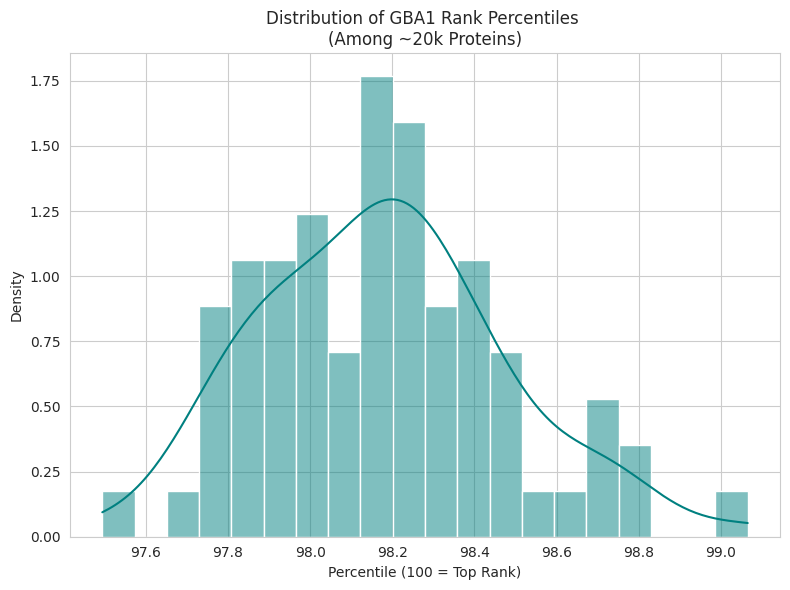

In [8]:
# Visualization: Percentile Distribution (1D)
plt.figure(figsize=(8, 6))

sns.histplot(results_df['Percentile'], bins=20, kde=True, color='teal', stat='density')
plt.title("Distribution of GBA1 Rank Percentiles \n(Among ~20k Proteins)")
plt.xlabel("Percentile (100 = Top Rank)")
plt.ylabel("Density")

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "data/notebooks/molecular_analysis/gba1_percentile_distribution.png")
plt.show()

In [9]:
# --- Recall @ K Utilities ---

def _safe_suffix(s: str) -> str:
    """Helper to sanitize scenario names for filenames."""
    return (
        s.lower()
        .replace("%", "pct")
        .replace("*", "x")
        .replace("/", "_")
        .replace(" ", "_")
        .replace("(", "")
        .replace(")", "")
        .replace(",", "")
        .replace("__", "_")
    )

def recall_at_k_table(scores: np.ndarray, active_indices: np.ndarray, k_values=(1, 2, 5, 10, 20)) -> pd.DataFrame:
    """
    Computes a table of Recall values at specified top K percentages.
    
    Args:
        scores: Array of scores for all candidates.
        active_indices: Indices of the 'active' hits within the scores array.
        k_values: List of percentages (e.g., 10 for top 10%) to evaluate.
        
    Returns:
        pd.DataFrame: Table of cutoff counts, recovered actives, and recall fractions.
    """
    scores = np.asarray(scores)
    active_indices = np.asarray(active_indices, dtype=int)
    sorted_indices = np.argsort(-scores) # Descending sort
    n = len(scores)
    n_act = len(active_indices)

    rows = []
    for k in k_values:
        cutoff = max(1, int(n * (k / 100.0)))
        topk = sorted_indices[:cutoff]
        recovered = np.isin(topk, active_indices).sum()
        rows.append(
            {
                "Top K%": k,
                "Cutoff (N)": cutoff,
                "Recovered": int(recovered),
                "Total Actives": int(n_act),
                "Recall": float(recovered / n_act) if n_act else np.nan,
            }
        )
    return pd.DataFrame(rows)

def plot_recall_at_k(scores, active_indices, title, filename_suffix, k_values=[10, 20, 30, 40, 50]):
    """
    Plots Recall @ K where K is the top X% of the full sorted list.
    """
    # Sort scores descending
    sorted_indices = np.argsort(-scores) 
    total_items = len(scores)
    total_actives = len(active_indices)
    
    if total_actives == 0:
        _logger.warning(f"No actives found for Recall@K plot: {title}")
        return

    recalls = []
    labels = []
    
    for k in k_values:
        cutoff = int(total_items * k / 100)
        top_k_indices = sorted_indices[:cutoff]
        
        recovered = np.isin(top_k_indices, active_indices).sum()
        recall = recovered / total_actives
        recalls.append(recall)
        labels.append(f"Top {k}%")
        
    plt.figure(figsize=(8, 6))
    base_palette = sns.color_palette("Blues", n_colors=len(k_values) + 2)
    colors = base_palette[2:] # skip the very lightest ones
    
    bars = plt.bar(labels, recalls, color=colors, edgecolor='black', alpha=0.9)
    
    plt.title(f"Recall @ Top K% - {title}", fontsize=14)
    plt.ylabel("Recall (Fraction of Actives Recovered)", fontsize=12)
    plt.ylim(0, 1.1) 
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2f}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
                 
    output_path = PROJECT_ROOT / f"data/notebooks/molecular_analysis/recall_at_k_{filename_suffix}.png"
    plt.savefig(output_path)
    _logger.info(f"Saved Recall@K plot to {output_path}")
    plt.show()

In [10]:
# # --- Proteome-wide Ranking for ALL Drugs ---
# _logger.info("Computing GBA1 rank for all existing drugs in the KG (Background Distribution)...")

# # 1. Identify Existing Drugs
# # We look for nodes of type 'drug' in the nodes dataframe loaded earlier
# drug_nodes = nodes[nodes['node_type'] == 'drug']
# existing_drug_indices = torch.tensor(drug_nodes['node_index'].values, dtype=torch.long)

# background_results = []
# query_edge_type = ("drug", "drug_protein", "gene/protein")

# _logger.info(f"Scoring {len(existing_drug_indices)} existing drugs against {len(protein_indices)} proteins...")

# # Define a batch size for existing drugs to potentially speed up slightly loop overhead
# # But since we do scoring inside, simple loop is robust.
# # We skip re-scoring the new hits since we have them in results_df, 
# # although for perfect consistency we could assist, but let's just append.

# for drug_idx_tensor in tqdm(existing_drug_indices, desc="Background Scoring"):
#     d_idx = drug_idx_tensor.item()
    
#     # Create batch: 1 Drug vs All Proteins
#     # Note: We use combined_embeddings which includes everything, 
#     # but existing drug indices point to the first part of it.
#     batch_src = torch.full((len(protein_indices),), d_idx, dtype=torch.long)
#     batch_dst = protein_indices
    
#     with torch.no_grad():
#         scores = pretrain_model.get_scores_from_embeddings(
#             batch_src, 
#             batch_dst, 
#             query_edge_type, 
#             embeddings=combined_embeddings, 
#             use_cache=False,
#             query_kg=kg
#         )
    
#     scores_np = scores.cpu().numpy()
    
#     # Get GBA1 score & Rank
#     gba1_score = scores_np[gba1_rank_position_idx]
    
#     # Rank = (count of scores > gba1_score) + 1
#     rank = np.sum(scores_np > gba1_score) + 1
#     percentile = (len(protein_indices) - rank) / len(protein_indices) * 100
    
#     background_results.append({
#         "Global Index": d_idx,
#         "Type": "Existing Drug",
#         "GBA1 Rank": rank,
#         "Percentile": percentile
#     })

# background_df = pd.DataFrame(background_results)

# # Combine with Hits Data
# # Ensure necessary columns are present in hits slice
# hits_subset = results_df[['GBA1 Rank', 'Percentile']].copy()
# hits_subset['Type'] = 'GBA1 Hit'
# # new_drug_indices was defined in Cell "Load New Drug Embeddings"
# hits_subset['Global Index'] = new_drug_indices.cpu().numpy()

# all_drugs_ranking_df = pd.concat([background_df, hits_subset], ignore_index=True)

# _logger.info(f"Combined Analysis Complete. Total Drug Candidates: {len(all_drugs_ranking_df)}")
# display(all_drugs_ranking_df.groupby('Type')['Percentile'].describe())

In [11]:
# # --- Visualization 1: Global Distribution of Percentiles ---
# plt.figure(figsize=(10, 6))

# # Histogram with KDE
# sns.histplot(
#     data=all_drugs_ranking_df, 
#     x="Percentile", 
#     bins=40, 
#     kde=True, 
#     stat="density", 
#     color="#4C72B0",
#     label="All Drugs"
# )

# # Highlight where hits generally fall (optional, maybe just vertical lines for mean?)
# # For now, just the distribution as requested.

# plt.title("Distribution of GBA1 Rank Percentiles \n(All KG Drugs + New Hits)", fontsize=14)
# plt.xlabel("GBA1 Percentile (100 = Top Rank)", fontsize=12)
# plt.ylabel("Density", fontsize=12)
# plt.legend()

# plt.tight_layout()
# plt.show()

Code cell below outputs all edge types in the knowledge graph, used for later reference.

In [12]:
# Output all edge types in the loaded DGL heterograph (kg)

canonical_etypes = list(kg.canonical_etypes)

edge_type_rows = []
for src_type, rel_type, dst_type in canonical_etypes:
    edge_type_rows.append(
        {
            "src_type": src_type,
            "relation": rel_type,
            "dst_type": dst_type,
            "num_edges": int(kg.num_edges((src_type, rel_type, dst_type))),
        }
    )

edge_types_df = pd.DataFrame(edge_type_rows).sort_values(
    ["src_type", "relation", "dst_type"]
).reset_index(drop=True)

print(f"Total canonical edge types: {len(canonical_etypes)}")
display(edge_types_df)

# Optional: raw tuple listing
print("\nCanonical edge types (src, rel, dst):")
for et in canonical_etypes:
    print(et)

Total canonical edge types: 94


,src_type,relation,dst_type,num_edges
0,anatomy,anatomy_anatomy,anatomy,14383
1,anatomy,anatomy_protein_absent,gene/protein,324186
2,anatomy,anatomy_protein_present,gene/protein,3831782
3,anatomy,rev_anatomy_anatomy,anatomy,14383
4,biological_process,bioprocess_bioprocess,biological_process,50232
...,...,...,...,...
89,molecular_function,rev_molfunc_molfunc,molecular_function,13735
90,molecular_function,rev_molfunc_protein,gene/protein,70291
91,pathway,pathway_pathway,pathway,2647
92,pathway,rev_pathway_pathway,pathway,2647



Canonical edge types (src, rel, dst):
('anatomy', 'anatomy_anatomy', 'anatomy')
('anatomy', 'anatomy_protein_absent', 'gene/protein')
('anatomy', 'anatomy_protein_present', 'gene/protein')
('anatomy', 'rev_anatomy_anatomy', 'anatomy')
('biological_process', 'bioprocess_bioprocess', 'biological_process')
('biological_process', 'bioprocess_protein', 'gene/protein')
('biological_process', 'exposure_bioprocess', 'exposure')
('biological_process', 'rev_bioprocess_bioprocess', 'biological_process')
('brain_region', 'region_structure', 'brain_structure')
('brain_structure', 'rev_region_structure', 'brain_region')
('brain_structure', 'structure_cell_type', 'cell_cluster')
('cell_cluster', 'cell_cluster_cell_subcluster', 'cell_subcluster')
('cell_cluster', 'cell_cluster_marker_gene', 'gene/protein')
('cell_cluster', 'cell_type_cell_cluster', 'cell_type')
('cell_cluster', 'rev_structure_cell_type', 'brain_structure')
('cell_subcluster', 'cell_subcluster_marker_gene', 'gene/protein')
('cell_subc

# Combined Ranking Analysis (GBA1 + Disease Indications)

In this section, we evaluate how the GBA1 hits rank against **all other drugs** in the knowledge graph across multiple scoring scenarios. 

We compute rankings efficiently for five scenarios:
1.  **GBA1 Only**: Hits ranked by affinity to GBA1.
2.  **Weighted**: $0.5 \times GBA1 + 0.25 \times Gaucher + 0.25 \times Parkinson$.
3.  **Disease Only**: $0.5 \times Gaucher + 0.5 \times Parkinson$.
4.  **Gaucher Only**.
5.  **Parkinson Only**.

We visualize the results by plotting the score curve of all drugs and marking the position of our candidates.

In [13]:
# 1. Identify All Drug Candidates & Compute Raw Scores
_logger.info("Identifying all drug candidates and scoring...")

# A. Candidates
drug_nodes = nodes[nodes['node_type'] == 'drug']
existing_drug_indices = torch.tensor(drug_nodes['node_index'].values, dtype=torch.long)
all_candidate_drug_indices = torch.cat([existing_drug_indices, new_drug_indices])
_logger.info(f"Total drug candidates: {len(all_candidate_drug_indices)}")

# B. GBA1 Score (Reverse Screening)
reverse_edge_type = ('gene/protein', 'rev_drug_protein', 'drug')
batch_src = torch.full((len(all_candidate_drug_indices),), gba1_global_idx, dtype=torch.long)
with torch.no_grad():
    score_gba1 = pretrain_model.get_scores_from_embeddings(
        batch_src, all_candidate_drug_indices, reverse_edge_type, 
        embeddings=combined_embeddings, use_cache=False, query_kg=kg
    ).cpu().numpy()

# C. Disease Scores (Gaucher & Parkinson)
disease_queries = ["Gaucher disease", "Parkinson disease"]
raw_disease_scores = {}

for query in disease_queries:
    # Find Node
    res = nodes[nodes['node_name'].astype(str).str.contains(query, case=False)]
    if len(res) > 0 and 'disease' in res['node_type'].values:
        d_node = res[res['node_type'] == 'disease'].iloc[0]
        # Specific fix for Parkinson exact match if needed
        if query == "Parkinson disease":
             exact = res[res['node_name'].str.lower() == "parkinson disease"]
             if len(exact) > 0: d_node = exact.iloc[0]
             
        _logger.info(f"Found {query}: {d_node['node_name']} (ID: {d_node['node_index']})")
        
        # Find Edge
        candidates = [et for et in kg.canonical_etypes if et[0] == d_node['node_type'] and et[2] == 'drug']
        if not candidates: continue
        selected_etype = next((et for et in candidates if 'indication' in et[1]), candidates[0])
        
        # Score
        batch_src_d = torch.full((len(all_candidate_drug_indices),), d_node['node_index'], dtype=torch.long)
        with torch.no_grad():
            d_scores = pretrain_model.get_scores_from_embeddings(
                batch_src_d, all_candidate_drug_indices, selected_etype, 
                embeddings=combined_embeddings, use_cache=False, query_kg=kg
            ).cpu().numpy()
        raw_disease_scores[query] = d_scores

_logger.info("Scoring complete.")

[02/04/26 23:04:54] INFO     Identifying all drug candidates and scoring...                          ]8;id=657917;file:///tmp/ipykernel_616431/975145318.py\975145318.py]8;;\:]8;id=384379;file:///tmp/ipykernel_616431/975145318.py#2\2]8;;\

                    INFO     Total drug candidates: 8232                                             ]8;id=159058;file:///tmp/ipykernel_616431/975145318.py\975145318.py]8;;\:]8;id=8023;file:///tmp/ipykernel_616431/975145318.py#8\8]8;;\

                    INFO     Found Gaucher disease: Gaucher disease type II (ID: 28143)             ]8;id=876472;file:///tmp/ipykernel_616431/975145318.py\975145318.py]8;;\:]8;id=405852;file:///tmp/ipykernel_616431/975145318.py#33\33]8;;\

                    INFO     Found Parkinson disease: Parkinson disease (ID: 39579)                 ]8;id=880623;file:///tmp/ipykernel_616431/975145318.py\975145318.py]8;;\:]8;id=836804;file:///tmp/ipykernel_616431/975145318.py#33\33]8;;\

                    INFO     Scoring complete.                                                      ]8;id=869752;file:///tmp/ipykernel_616431/975145318.py\975145318.py]8;;\:]8;id=1750;file:///tmp/ipykernel_616431/975145318.py#49\49]8;;\

                    INFO     Found special molecule NCGC00241326-01 at rank index 8191              ]8;id=915339;file:///tmp/ipykernel_616431/506049190.py\506049190.py]8;;\:]8;id=473243;file:///tmp/ipykernel_616431/506049190.py#33\33]8;;\

                    INFO     Scenario GBA1 Only - Median Hit Rank: 5390 / 8232                      ]8;id=856361;file:///tmp/ipykernel_616431/506049190.py\506049190.py]8;;\:]8;id=789160;file:///tmp/ipykernel_616431/506049190.py#77\77]8;;\

                    INFO     Scenario Weighted (0.5*GBA1 + 0.25*GD + 0.25*PD) - Median Hit Rank:    ]8;id=858968;file:///tmp/ipykernel_616431/506049190.py\506049190.py]8;;\:]8;id=598071;file:///tmp/ipykernel_616431/506049190.py#77\77]8;;\
                             4786 / 8232                                                                           

                    INFO     Scenario Disease Only (0.5*GD + 0.5*PD) - Median Hit Rank: 3422 / 8232 ]8;id=767675;file:///tmp/ipykernel_616431/506049190.py\506049190.py]8;;\:]8;id=701777;file:///tmp/ipykernel_616431/506049190.py#77\77]8;;\

                    INFO     Scenario Gaucher Only - Median Hit Rank: 3327 / 8232                   ]8;id=13858;file:///tmp/ipykernel_616431/506049190.py\506049190.py]8;;\:]8;id=519866;file:///tmp/ipykernel_616431/506049190.py#77\77]8;;\

                    INFO     Scenario Parkinson Only - Median Hit Rank: 3588 / 8232                 ]8;id=160992;file:///tmp/ipykernel_616431/506049190.py\506049190.py]8;;\:]8;id=36140;file:///tmp/ipykernel_616431/506049190.py#77\77]8;;\

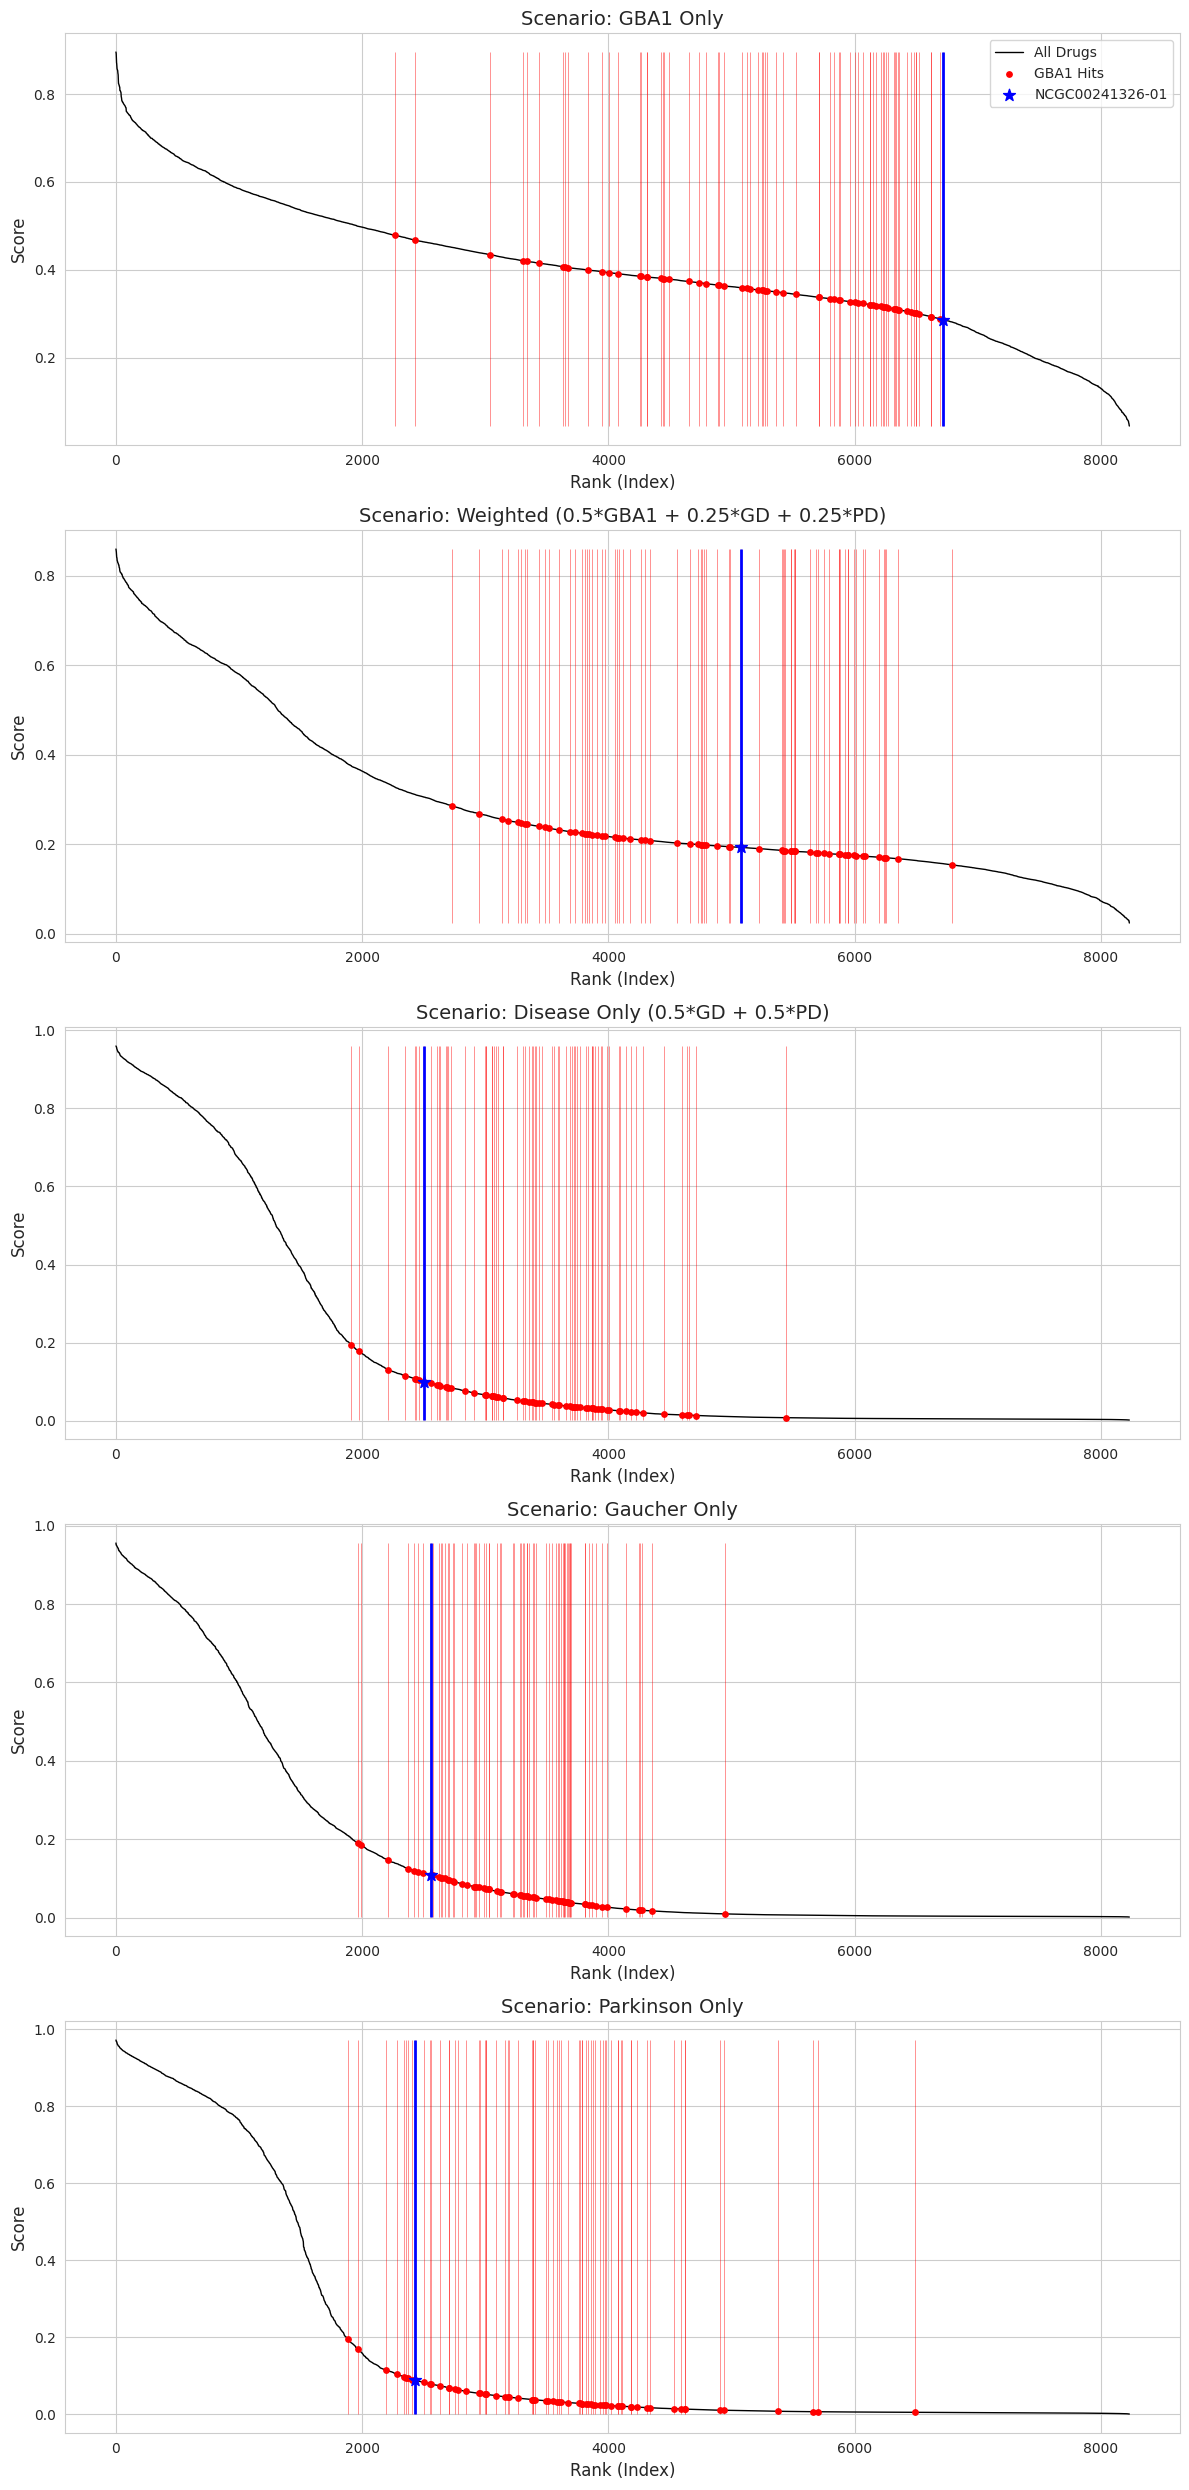

In [14]:
# 2. Scenarios and Visualization
# Clean up missing keys safely
gd_score = raw_disease_scores.get("Gaucher disease", np.zeros_like(score_gba1))
pd_score = raw_disease_scores.get("Parkinson disease", np.zeros_like(score_gba1))

scenarios = {
    "GBA1 Only": score_gba1,
    "Weighted (0.5*GBA1 + 0.25*GD + 0.25*PD)": 0.5 * score_gba1 + 0.25 * gd_score + 0.25 * pd_score,
    "Disease Only (0.5*GD + 0.5*PD)": 0.5 * gd_score + 0.5 * pd_score,
    "Gaucher Only": gd_score,
    "Parkinson Only": pd_score
}

# Where are our hits in the 'all_candidate_drug_indices' array?
# They are appended at the end.
num_existing = len(existing_drug_indices)
hit_indices_local = np.arange(num_existing, len(all_candidate_drug_indices))

# Highlight logic for NCGC00241326-01
special_id = "NCGC00241326-01"
special_global_idx = None

# Identify index in hits_df (which aligns with new_drug_indices)
# hits_df was loaded/filtered in previous cells
search_col = 'Sample Data Type' if 'Sample Data Type' in hits_df.columns else 'Sample Name'
matches = hits_df[hits_df[search_col].astype(str).str.strip() == special_id]

if len(matches) > 0:
    # Index in hits_df (0 to 72)
    idx_in_hits = matches.index[0]
    # Index in all_candidate_drug_indices
    special_global_idx = num_existing + idx_in_hits
    _logger.info(f"Found special molecule {special_id} at rank index {special_global_idx}")
else:
    _logger.warning(f"Special molecule {special_id} not found in hits dataframe.")


# Plotting
fig, axes = plt.subplots(len(scenarios), 1, figsize=(12, 5 * len(scenarios)))
if len(scenarios) == 1: axes = [axes]

for ax, (name, scores) in zip(axes, scenarios.items()):
    # Sort
    sorted_indices = np.argsort(-scores) # Descending
    sorted_scores = scores[sorted_indices]
    
    # Plot Curve
    ax.plot(np.arange(len(sorted_scores)), sorted_scores, color='black', linewidth=1, label='All Drugs')
    
    # Find hits positions
    # Boolean mask of sorted list where item is a hit
    is_hit = np.isin(sorted_indices, hit_indices_local)
    hit_ranks = np.where(is_hit)[0]
    hit_scores = sorted_scores[is_hit]
    
    # Add vertical lines for hits
    ax.vlines(hit_ranks, ymin=min(sorted_scores), ymax=max(sorted_scores), color='red', alpha=0.6, linewidth=0.5)
    # Add scatter for visibility on the line
    ax.scatter(hit_ranks, hit_scores, color='red', s=15, zorder=3, label='GBA1 Hits' if ax == axes[0] else "")
    
    # Highlight Special
    if special_global_idx is not None:
        rank_pos = np.where(sorted_indices == special_global_idx)[0]
        if len(rank_pos) > 0:
            s_rank = rank_pos[0]
            s_score = scores[special_global_idx]
            
            ax.vlines(s_rank, ymin=min(sorted_scores), ymax=max(sorted_scores), color='blue', alpha=1.0, linewidth=2.0)
            ax.scatter(s_rank, s_score, color='blue', s=80, marker='*', zorder=4, label=f"{special_id}" if ax == axes[0] else "")

    ax.set_title(f"Scenario: {name}", fontsize=14)
    ax.set_xlabel("Rank (Index)", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    if ax == axes[0]: ax.legend()
    
    # Print stats
    _logger.info(f"Scenario {name} - Median Hit Rank: {np.median(hit_ranks):.0f} / {len(scores)}")

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "data/notebooks/molecular_analysis/gba1_scenarios_rank_curves.png")
plt.show()

[02/04/26 23:52:28] INFO     PD node idx: 39579 | 1-hop drug neighbors: 106                        ]8;id=430547;file:///tmp/ipykernel_616431/2797466288.py\2797466288.py]8;;\:]8;id=306146;file:///tmp/ipykernel_616431/2797466288.py#65\65]8;;\

                    INFO     GD node idx: 35206 | 1-hop drug neighbors: 11                         ]8;id=70331;file:///tmp/ipykernel_616431/2797466288.py\2797466288.py]8;;\:]8;id=930834;file:///tmp/ipykernel_616431/2797466288.py#66\66]8;;\

                    INFO     GBA1 node idx: 1720 | within-2-hop drug nodes: 1103                   ]8;id=949799;file:///tmp/ipykernel_616431/2797466288.py\2797466288.py]8;;\:]8;id=311725;file:///tmp/ipykernel_616431/2797466288.py#67\67]8;;\

                    INFO     Excluding total unique drugs (PD 1-hop ∪ GD 1-hop ∪ GBA1 ≤2-hop):     ]8;id=996076;file:///tmp/ipykernel_616431/2797466288.py\2797466288.py]8;;\:]8;id=915930;file:///tmp/ipykernel_616431/2797466288.py#68\68]8;;\
                             1103                                                                                  

                    INFO     Excluded 1103 / 8232 candidate drugs due to PD/GD 1-hop and GBA1      ]8;id=921058;file:///tmp/ipykernel_616431/2797466288.py\2797466288.py]8;;\:]8;id=899754;file:///tmp/ipykernel_616431/2797466288.py#82\82]8;;\
                             ≤2-hop filtering.                                                                     

                    INFO     [Filtered] Scenario GBA1 Only - Median Hit Rank: 4408 / 7129         ]8;id=622640;file:///tmp/ipykernel_616431/2797466288.py\2797466288.py]8;;\:]8;id=667324;file:///tmp/ipykernel_616431/2797466288.py#129\129]8;;\

                    INFO     [Filtered] Scenario Weighted (0.5*GBA1 + 0.25*GD + 0.25*PD) - Median ]8;id=349152;file:///tmp/ipykernel_616431/2797466288.py\2797466288.py]8;;\:]8;id=875509;file:///tmp/ipykernel_616431/2797466288.py#129\129]8;;\
                             Hit Rank: 3732 / 7129                                                                 

                    INFO     [Filtered] Scenario Disease Only (0.5*GD + 0.5*PD) - Median Hit      ]8;id=138037;file:///tmp/ipykernel_616431/2797466288.py\2797466288.py]8;;\:]8;id=346087;file:///tmp/ipykernel_616431/2797466288.py#129\129]8;;\
                             Rank: 2408 / 7129                                                                     

                    INFO     [Filtered] Scenario Gaucher Only - Median Hit Rank: 2318 / 7129      ]8;id=563343;file:///tmp/ipykernel_616431/2797466288.py\2797466288.py]8;;\:]8;id=679761;file:///tmp/ipykernel_616431/2797466288.py#129\129]8;;\

                    INFO     [Filtered] Scenario Parkinson Only - Median Hit Rank: 2568 / 7129    ]8;id=562220;file:///tmp/ipykernel_616431/2797466288.py\2797466288.py]8;;\:]8;id=104329;file:///tmp/ipykernel_616431/2797466288.py#129\129]8;;\

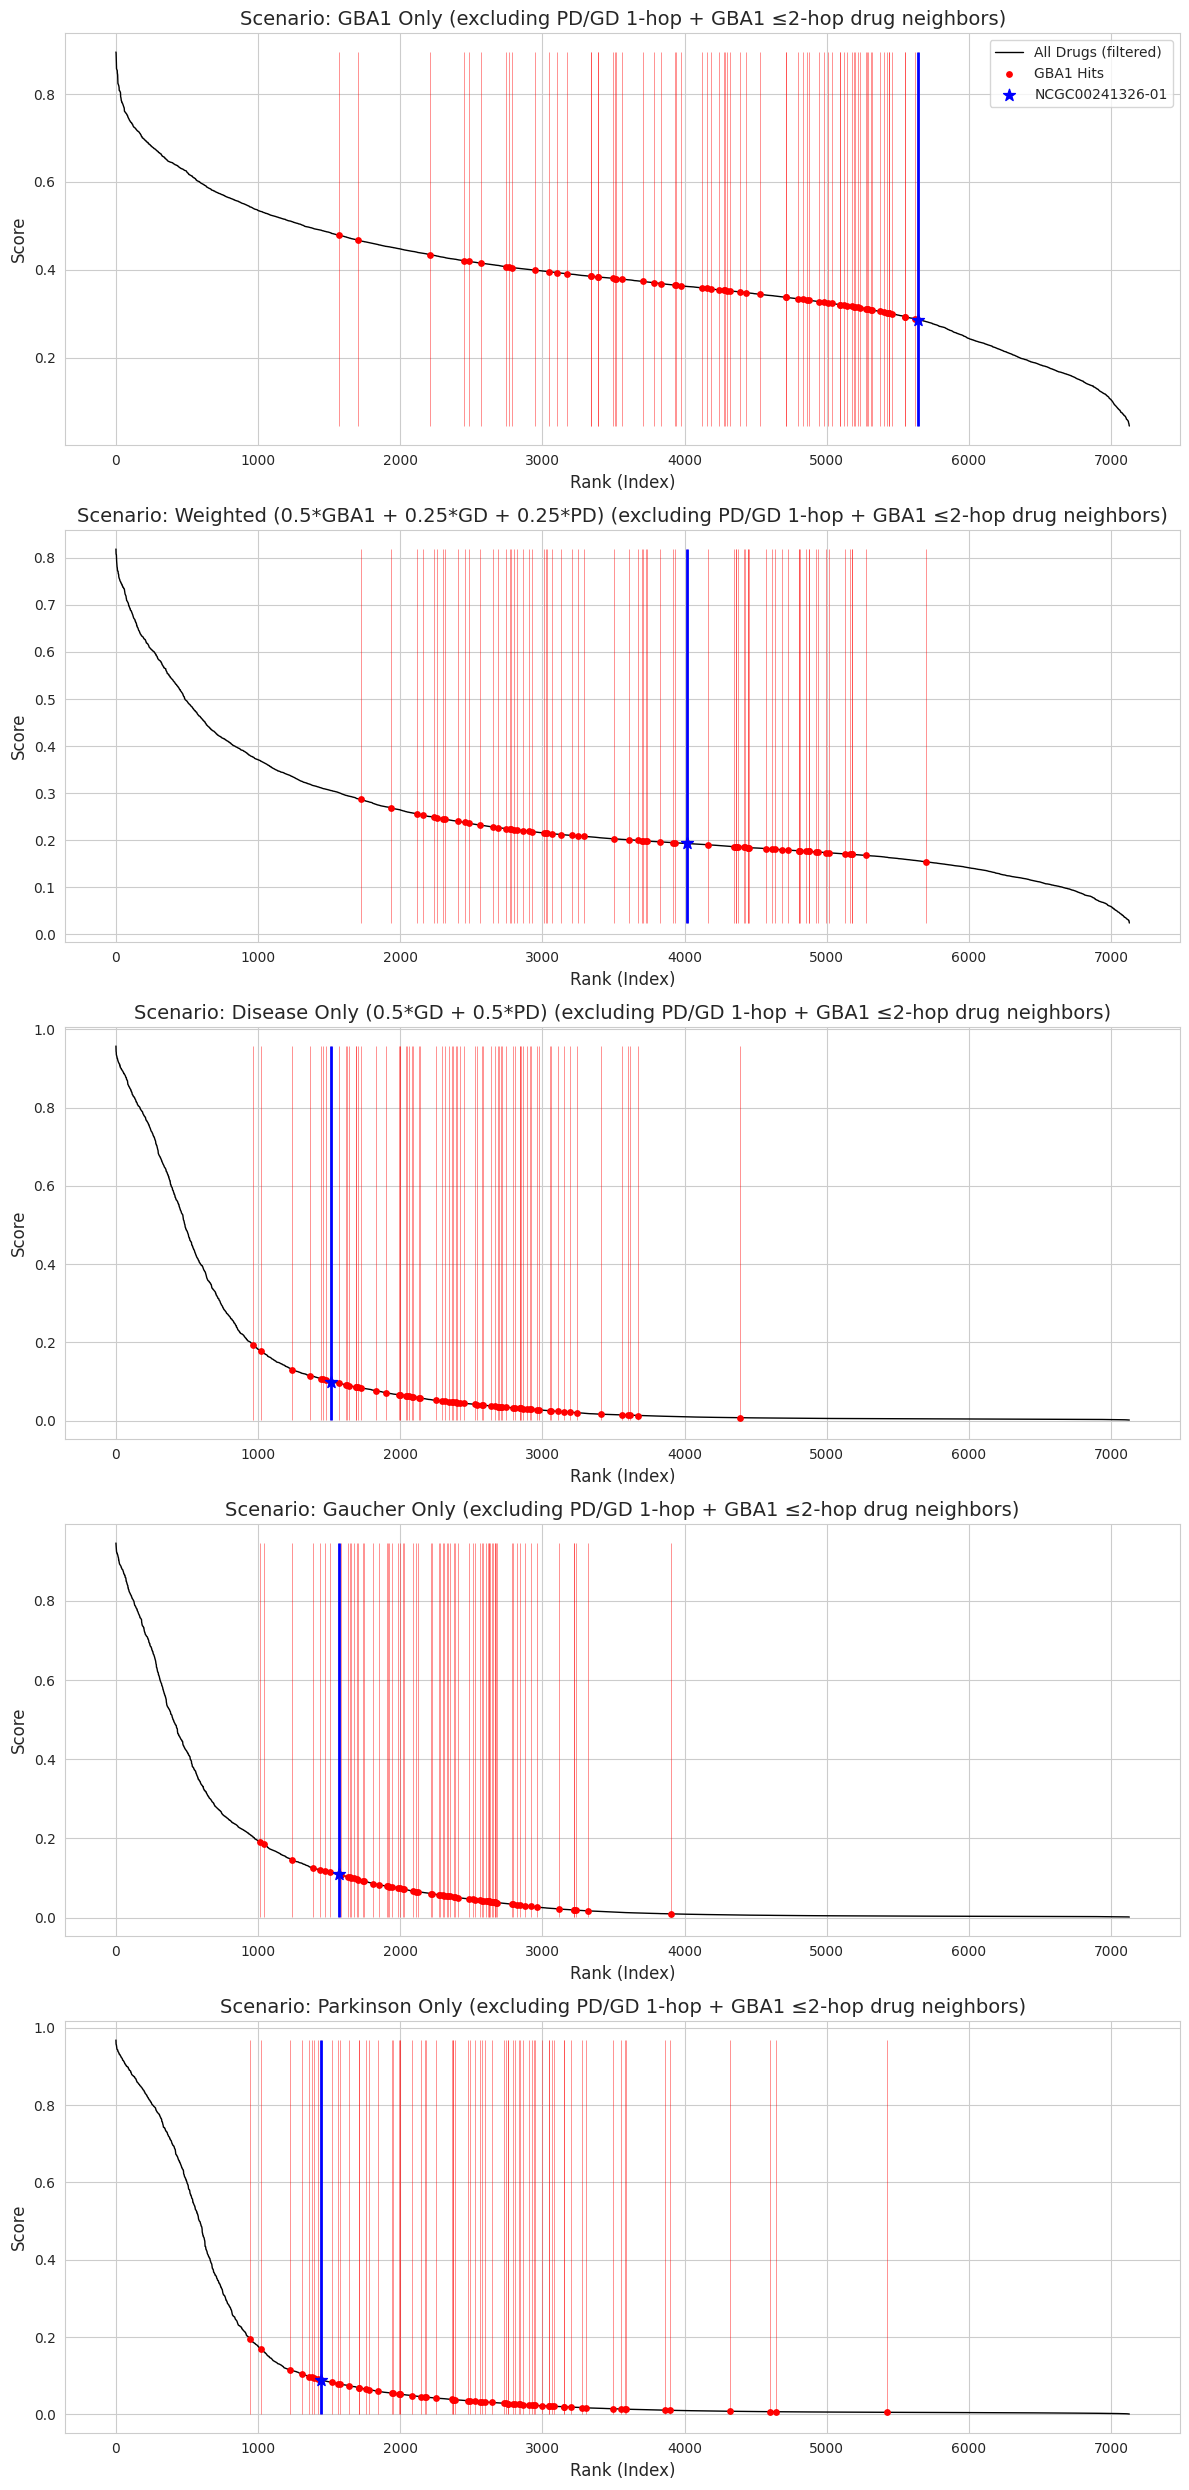

In [28]:
# --- Rank-vs-score curves excluding confounded drug neighborhoods in NeuroKG ---
# Reproduces the scenario plots above, but filters out any *drug* node that is either:
#  (a) 1-hop connected to Parkinson disease or Gaucher disease, OR
#  (b) within 2 hops of GBA1 (via any intermediate node types), based on the KG `edges` table.

if not ("nodes" in globals() and "edges" in globals()):
    raise RuntimeError("Expected `nodes` and `edges` to be loaded (see earlier cells).")

# Robust node lookup (reuse helper from earlier cell if present)
if "_find_node_idx" not in globals():
    def _find_node_idx(node_name: str) -> int:
        exact = nodes.loc[nodes["node_name"].astype(str) == node_name, "node_index"]
        if len(exact) > 0:
            return int(exact.iloc[0])
        approx = nodes.loc[
            nodes["node_name"].astype(str).str.contains(node_name, case=False, na=False),
            "node_index",
        ]
        if len(approx) == 0:
            raise ValueError(f"Could not find node '{node_name}' in nodes table.")
        return int(approx.iloc[0])

# Drug index set (global indices)
if "drug_idx_set" not in globals():
    drug_idx_set = set(nodes.loc[nodes["node_type"].astype(str) == "drug", "node_index"].astype(int).values)

def _one_hop_neighbors(seed_idx: int) -> set[int]:
    m = (edges["x_index"] == seed_idx) | (edges["y_index"] == seed_idx)
    if not m.any():
        return set()
    x = edges.loc[m, "x_index"].to_numpy()
    y = edges.loc[m, "y_index"].to_numpy()
    nbrs = set(np.concatenate([x, y]).astype(int))
    nbrs.discard(int(seed_idx))
    return nbrs

def _one_hop_drug_neighbors(seed_idx: int) -> set[int]:
    return _one_hop_neighbors(seed_idx) & drug_idx_set

def _within_two_hops(seed_idx: int) -> set[int]:
    n1 = _one_hop_neighbors(seed_idx)
    if len(n1) == 0:
        return set()
    m2 = edges["x_index"].isin(n1) | edges["y_index"].isin(n1)
    x2 = edges.loc[m2, "x_index"].to_numpy()
    y2 = edges.loc[m2, "y_index"].to_numpy()
    n_within2 = set(np.concatenate([x2, y2]).astype(int))
    n_within2.discard(int(seed_idx))
    return n_within2

# --- Build exclusion set ---
pd_idx = _find_node_idx("Parkinson disease")
gd_idx = _find_node_idx("Gaucher disease")
gba1_idx = int(globals().get("gba1_global_idx", _find_node_idx("GBA1")))

pd_drugs = _one_hop_drug_neighbors(pd_idx)
gd_drugs = _one_hop_drug_neighbors(gd_idx)

# Drugs within 2 hops of GBA1 (includes 1-hop and 2-hop drugs)
gba1_within2 = _within_two_hops(gba1_idx)
gba1_within2_drugs = gba1_within2 & drug_idx_set

excluded_drug_global_indices = (pd_drugs | gd_drugs | gba1_within2_drugs)

_logger.info(f"PD node idx: {pd_idx} | 1-hop drug neighbors: {len(pd_drugs)}")
_logger.info(f"GD node idx: {gd_idx} | 1-hop drug neighbors: {len(gd_drugs)}")
_logger.info(f"GBA1 node idx: {gba1_idx} | within-2-hop drug nodes: {len(gba1_within2_drugs)}")
_logger.info(
    f"Excluding total unique drugs (PD 1-hop ∪ GD 1-hop ∪ GBA1 ≤2-hop): {len(excluded_drug_global_indices)}"
 )

if "all_candidate_drug_indices" not in globals():
    raise RuntimeError("Expected `all_candidate_drug_indices` to exist (see NeuroKG scoring section).")
if "scenarios" not in globals():
    raise RuntimeError("Expected `scenarios` dict to exist (see scenario plot cell above).")

# Build keep mask over the candidate list order (scores align to this order)
candidate_global = all_candidate_drug_indices.detach().cpu().numpy().astype(int)
keep_mask = np.array([idx not in excluded_drug_global_indices for idx in candidate_global], dtype=bool)

excluded_count = int((~keep_mask).sum())
_logger.info(
    f"Excluded {excluded_count} / {len(candidate_global)} candidate drugs due to PD/GD 1-hop and GBA1 ≤2-hop filtering."
 )

# Map old positions -> new positions after filtering (for hit/special highlighting)
keep_positions = np.flatnonzero(keep_mask)
old_to_new = -np.ones(len(candidate_global), dtype=int)
old_to_new[keep_positions] = np.arange(len(keep_positions))

# Update hit indices after filtering
if "hit_indices_local" in globals():
    hit_indices_local_excl = old_to_new[hit_indices_local]
    hit_indices_local_excl = hit_indices_local_excl[hit_indices_local_excl >= 0]
else:
    _logger.warning("`hit_indices_local` missing; hits will not be highlighted in filtered plots.")
    hit_indices_local_excl = np.array([], dtype=int)

# Update special molecule index after filtering
special_global_idx_excl = None
if "special_global_idx" in globals() and special_global_idx is not None:
    mapped = int(old_to_new[int(special_global_idx)])
    if mapped >= 0:
        special_global_idx_excl = mapped
    else:
        _logger.warning("Special molecule was excluded by filtering; it will not be highlighted.")

# Plot filtered scenarios
fig, axes = plt.subplots(len(scenarios), 1, figsize=(12, 5 * len(scenarios)))
if len(scenarios) == 1:
    axes = [axes]

for ax, (name, scores) in zip(axes, scenarios.items()):
    scores_f = np.asarray(scores)[keep_mask]
    sorted_indices = np.argsort(-scores_f)  # Descending
    sorted_scores = scores_f[sorted_indices]
    
    ax.plot(np.arange(len(sorted_scores)), sorted_scores, color='black', linewidth=1, label='All Drugs (filtered)')
    
    if len(hit_indices_local_excl) > 0:
        is_hit = np.isin(sorted_indices, hit_indices_local_excl)
        hit_ranks = np.where(is_hit)[0]
        hit_scores = sorted_scores[is_hit]
        ax.vlines(
            hit_ranks, ymin=float(np.min(sorted_scores)), ymax=float(np.max(sorted_scores)),
            color='red', alpha=0.6, linewidth=0.5
        )
        ax.scatter(hit_ranks, hit_scores, color='red', s=15, zorder=3, label='GBA1 Hits' if ax == axes[0] else "")
        _logger.info(f"[Filtered] Scenario {name} - Median Hit Rank: {np.median(hit_ranks):.0f} / {len(scores_f)}")
    else:
        _logger.info(f"[Filtered] Scenario {name} - No hits to plot (after filtering or missing hit indices).")
    
    if special_global_idx_excl is not None:
        rank_pos = np.where(sorted_indices == special_global_idx_excl)[0]
        if len(rank_pos) > 0:
            s_rank = int(rank_pos[0])
            s_score = float(scores_f[special_global_idx_excl])
            ax.vlines(
                s_rank, ymin=float(np.min(sorted_scores)), ymax=float(np.max(sorted_scores)),
                color='blue', alpha=1.0, linewidth=2.0
            )
            ax.scatter(s_rank, s_score, color='blue', s=80, marker='*', zorder=4, label=f"{special_id}" if ax == axes[0] else "")
    
    ax.set_title(f"Scenario: {name} (excluding PD/GD 1-hop + GBA1 ≤2-hop drug neighbors)", fontsize=14)
    ax.set_xlabel("Rank (Index)", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    if ax == axes[0]:
        ax.legend()

plt.tight_layout()
plt.savefig(
    PROJECT_ROOT / "data/notebooks/molecular_analysis/gba1_scenarios_rank_curves_excluding_pd_gd_and_gba1_2hop_neighbors.png"
 )
plt.show()

[02/04/26 23:54:21] INFO     Computing Recall @ K% for KG scenario rank curves...                    ]8;id=9728;file:///tmp/ipykernel_616431/510504898.py\510504898.py]8;;\:]8;id=517542;file:///tmp/ipykernel_616431/510504898.py#4\4]8;;\

[02/04/26 23:54:22] INFO     Saved Recall@K plot to                                                ]8;id=33119;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=601707;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_kg_gba1_only.png                                         

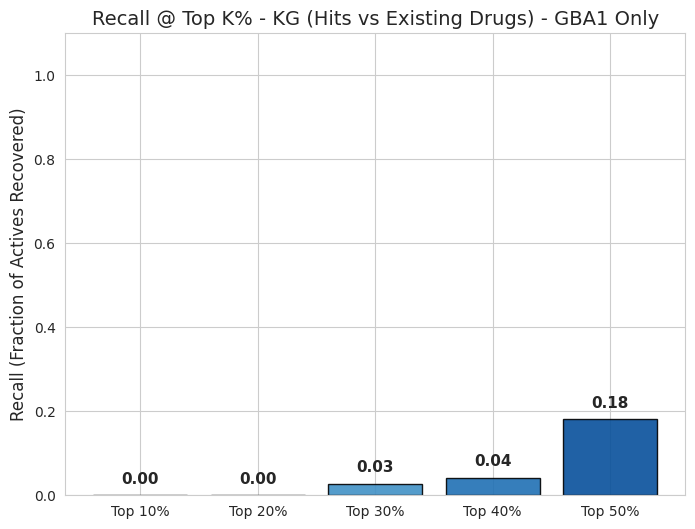

Recall Table: GBA1 Only


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,823,0,72,0.000000
1,20,1646,0,72,0.000000
2,30,2469,2,72,0.027778
3,40,3292,3,72,0.041667
4,50,4116,13,72,0.180556


                    INFO     Saved Recall@K plot to                                                ]8;id=447527;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=395742;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_kg_weighted_0.5xgba1_+_0.25xgd_+_0.25xpd                 
                             .png                                                                                  

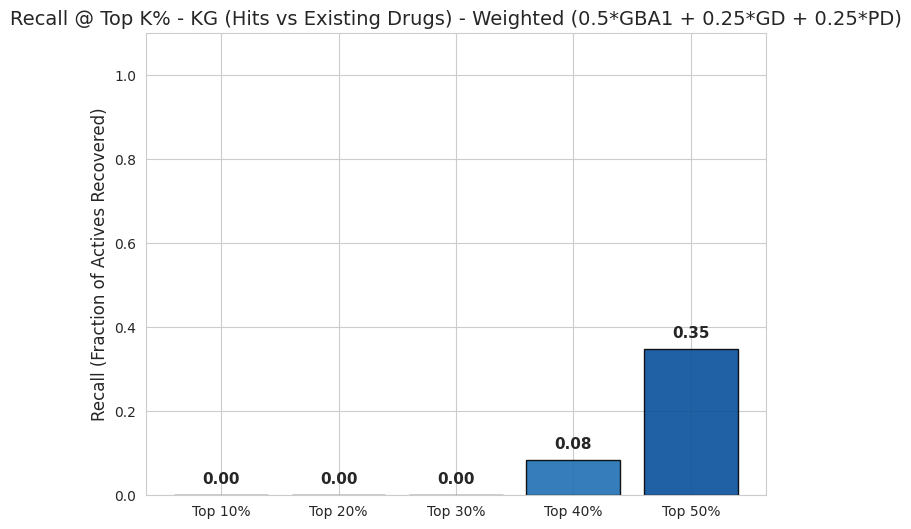

Recall Table: Weighted (0.5*GBA1 + 0.25*GD + 0.25*PD)


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,823,0,72,0.000000
1,20,1646,0,72,0.000000
2,30,2469,0,72,0.000000
3,40,3292,6,72,0.083333
4,50,4116,25,72,0.347222


                    INFO     Saved Recall@K plot to                                                ]8;id=27042;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=267894;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_kg_disease_only_0.5xgd_+_0.5xpd.png                      

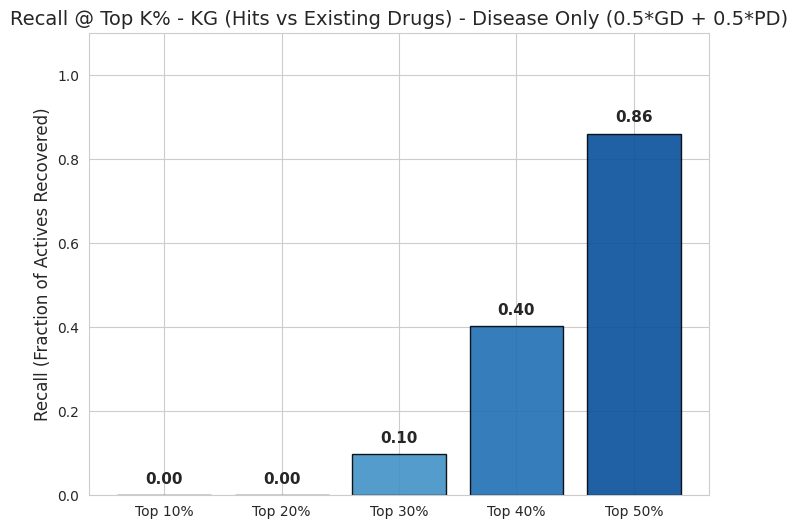

Recall Table: Disease Only (0.5*GD + 0.5*PD)


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,823,0,72,0.000000
1,20,1646,0,72,0.000000
2,30,2469,7,72,0.097222
3,40,3292,29,72,0.402778
4,50,4116,62,72,0.861111


                    INFO     Saved Recall@K plot to                                                ]8;id=693902;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=108817;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_kg_gaucher_only.png                                      

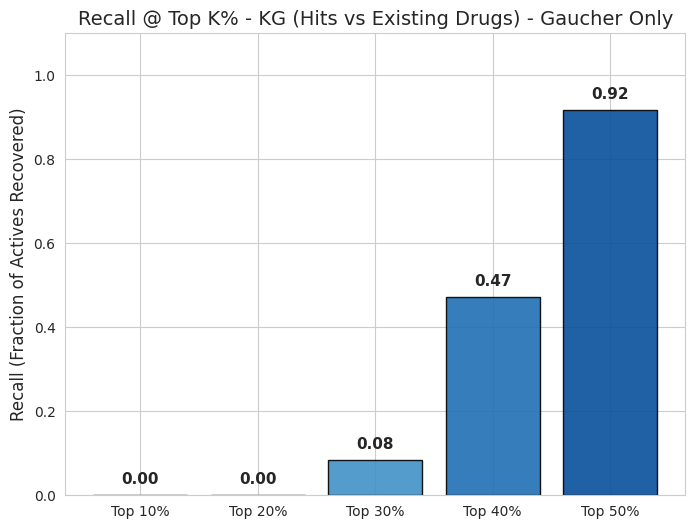

Recall Table: Gaucher Only


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,823,0,72,0.000000
1,20,1646,0,72,0.000000
2,30,2469,6,72,0.083333
3,40,3292,34,72,0.472222
4,50,4116,66,72,0.916667


[02/04/26 23:54:23] INFO     Saved Recall@K plot to                                                ]8;id=726750;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=10362;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_kg_parkinson_only.png                                    

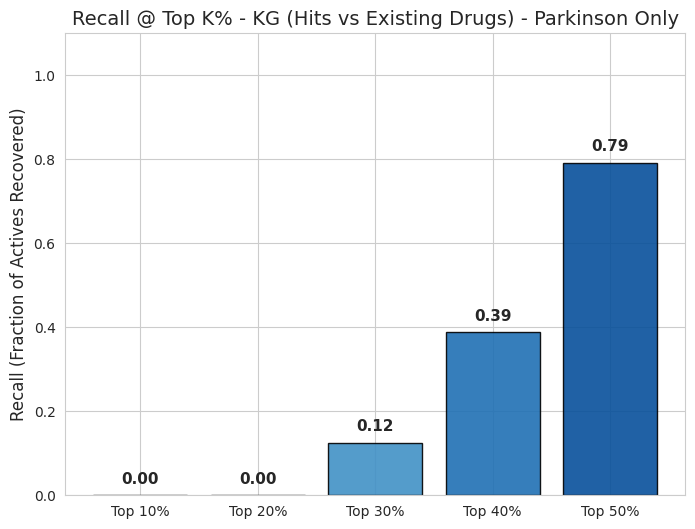

Recall Table: Parkinson Only


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,823,0,72,0.000000
1,20,1646,0,72,0.000000
2,30,2469,9,72,0.125000
3,40,3292,28,72,0.388889
4,50,4116,57,72,0.791667


                    INFO     Computing Recall @ K% for FILTERED KG scenario rank curves (exclusions ]8;id=189438;file:///tmp/ipykernel_616431/510504898.py\510504898.py]8;;\:]8;id=419168;file:///tmp/ipykernel_616431/510504898.py#29\29]8;;\
                             applied)...                                                                           

                    INFO     Saved Recall@K plot to                                                ]8;id=992360;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=180035;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_kg_filtered_excl_pd_gd_gba1_2hop_gba1_on                 
                             ly.png                                                                                

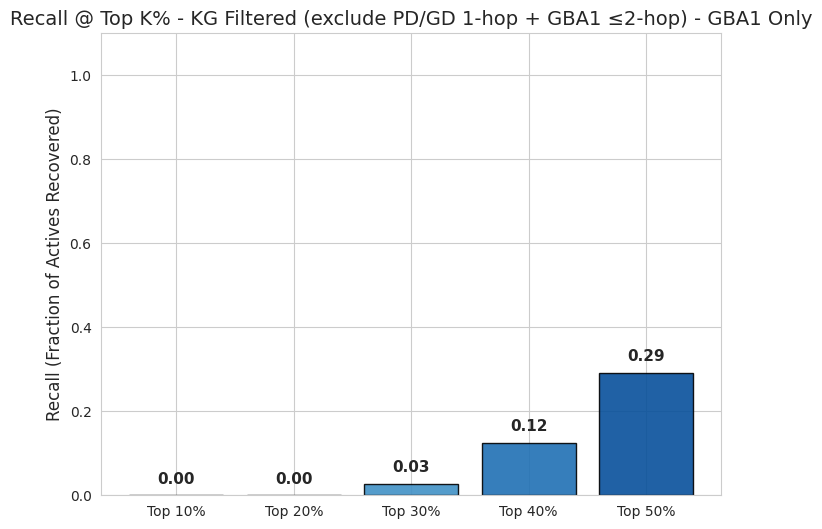

Filtered Recall Table: GBA1 Only


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,712,0,72,0.000000
1,20,1425,0,72,0.000000
2,30,2138,2,72,0.027778
3,40,2851,9,72,0.125000
4,50,3564,21,72,0.291667


                    INFO     Saved Recall@K plot to                                                ]8;id=197092;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=486139;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_kg_filtered_excl_pd_gd_gba1_2hop_weighte                 
                             d_0.5xgba1_+_0.25xgd_+_0.25xpd.png                                                    

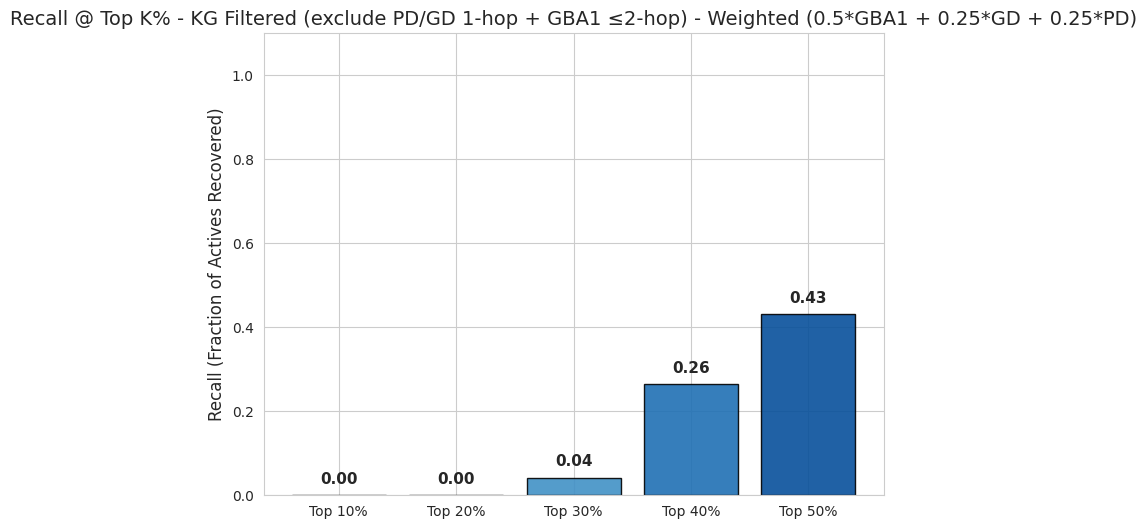

Filtered Recall Table: Weighted (0.5*GBA1 + 0.25*GD + 0.25*PD)


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,712,0,72,0.000000
1,20,1425,0,72,0.000000
2,30,2138,3,72,0.041667
3,40,2851,19,72,0.263889
4,50,3564,31,72,0.430556


                    INFO     Saved Recall@K plot to                                                ]8;id=985415;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=284206;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_kg_filtered_excl_pd_gd_gba1_2hop_disease                 
                             _only_0.5xgd_+_0.5xpd.png                                                             

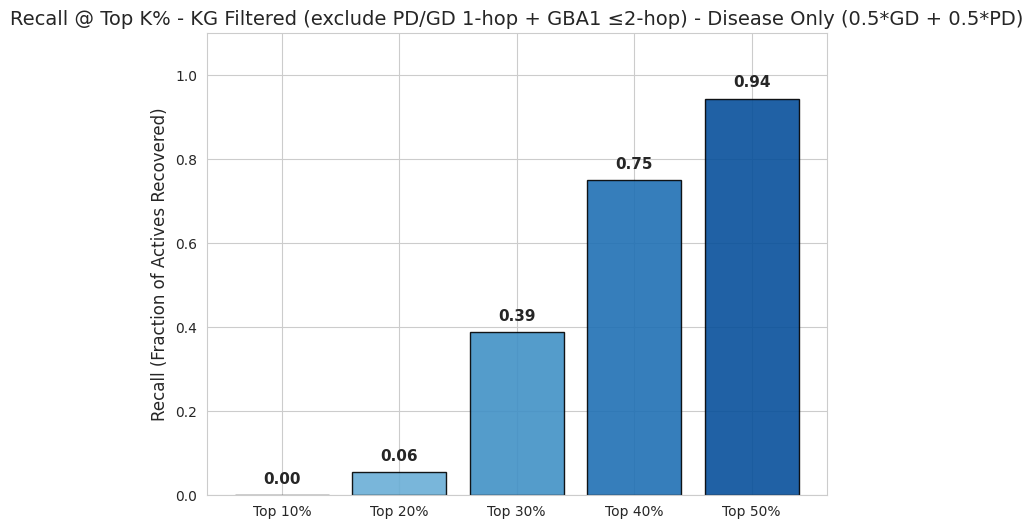

Filtered Recall Table: Disease Only (0.5*GD + 0.5*PD)


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,712,0,72,0.000000
1,20,1425,4,72,0.055556
2,30,2138,28,72,0.388889
3,40,2851,54,72,0.750000
4,50,3564,68,72,0.944444


                    INFO     Saved Recall@K plot to                                                ]8;id=731847;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=130150;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_kg_filtered_excl_pd_gd_gba1_2hop_gaucher                 
                             _only.png                                                                             

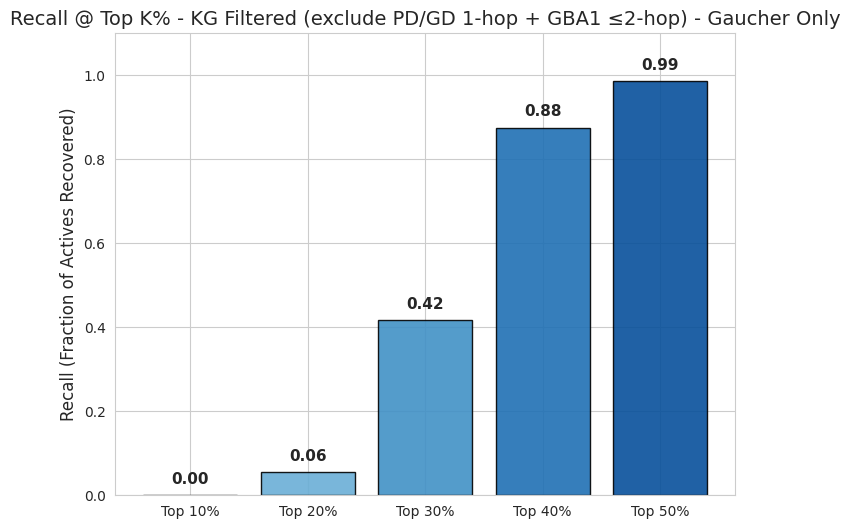

Filtered Recall Table: Gaucher Only


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,712,0,72,0.000000
1,20,1425,4,72,0.055556
2,30,2138,30,72,0.416667
3,40,2851,63,72,0.875000
4,50,3564,71,72,0.986111


                    INFO     Saved Recall@K plot to                                                ]8;id=870214;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=684829;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_kg_filtered_excl_pd_gd_gba1_2hop_parkins                 
                             on_only.png                                                                           

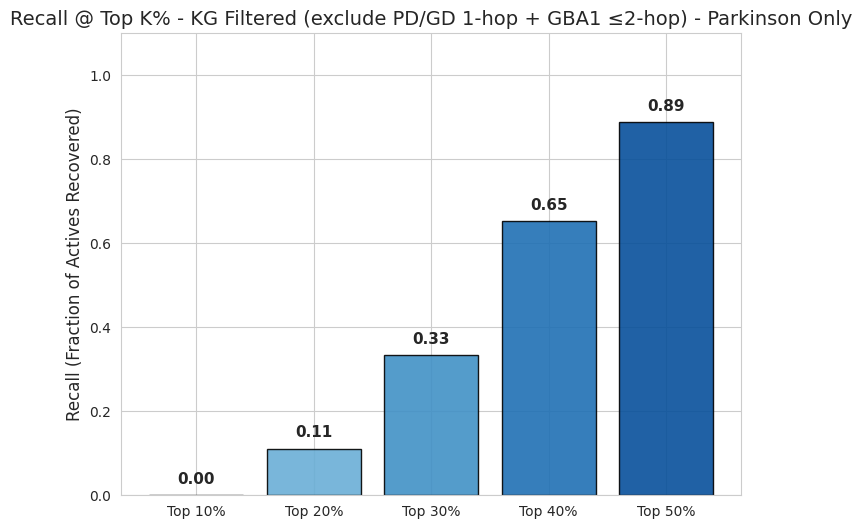

Filtered Recall Table: Parkinson Only


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,712,0,72,0.000000
1,20,1425,8,72,0.111111
2,30,2138,24,72,0.333333
3,40,2851,47,72,0.652778
4,50,3564,64,72,0.888889


In [29]:
# --- Recall @ Top K% for NeuroKG Background Scenarios ---
# Uses the 'scenarios' dictionary and 'hit_indices_local' computed in the previous section.

_logger.info("Computing Recall @ K% for KG scenario rank curves...")

k_values_kg = [10, 20, 30, 40, 50]

# 1) Original (unfiltered) NeuroKG background recall
if "scenarios" in globals() and "hit_indices_local" in globals():
    for scen_name, scen_scores in scenarios.items():
        suffix = f"kg_{_safe_suffix(scen_name)}"
        
        # 1. Plot Bar Chart
        plot_recall_at_k(
            scores=scen_scores,
            active_indices=hit_indices_local,
            title=f"KG (Hits vs Existing Drugs) - {scen_name}",
            filename_suffix=suffix,
            k_values=k_values_kg,
        )
        
        # 2. Display Table
        print(f"Recall Table: {scen_name}")
        display(recall_at_k_table(scen_scores, hit_indices_local, k_values=k_values_kg))
else:
    _logger.warning("Skipping KG Recall analysis: 'scenarios' or 'hit_indices_local' missing.")

# 2) Filtered NeuroKG background recall (excluding PD/GD 1-hop + GBA1 ≤2-hop drug neighbors)
_logger.info("Computing Recall @ K% for FILTERED KG scenario rank curves (exclusions applied)...")

required = ("scenarios" in globals()) and ("keep_mask" in globals()) and ("hit_indices_local_excl" in globals())
if required:
    for scen_name, scen_scores in scenarios.items():
        scen_scores_f = np.asarray(scen_scores)[keep_mask]
        suffix = f"kg_filtered_excl_pd_gd_gba1_2hop_{_safe_suffix(scen_name)}"
        
        plot_recall_at_k(
            scores=scen_scores_f,
            active_indices=hit_indices_local_excl,
            title=f"KG Filtered (exclude PD/GD 1-hop + GBA1 ≤2-hop) - {scen_name}",
            filename_suffix=suffix,
            k_values=k_values_kg,
        )
        
        print(f"Filtered Recall Table: {scen_name}")
        display(recall_at_k_table(scen_scores_f, hit_indices_local_excl, k_values=k_values_kg))
else:
    _logger.warning(
        "Skipping FILTERED KG Recall analysis: need `scenarios`, `keep_mask`, and `hit_indices_local_excl` (run the filtered rank-curve cell first)."
    )

# ChEMBL Background Analysis

In this section, we benchmark the GBA1 hits against a background of ~20,000 random ChEMBL molecules. We use a merged dataset containing both the GBA1 hits and ChEMBL decoys to assess if our hits consistently rank higher than random active-like molecules across the disease scoring scenarios.

In [16]:
# 1. Load Merged GBA1 + ChEMBL Dataset
merged_csv_path = PROJECT_ROOT / "notebooks/molecular_analysis/filtered_chembl_gba1_merged_filtered_molecules_with_embeddings.csv"
merged_emb_path = PROJECT_ROOT / "notebooks/molecular_analysis/filtered_chembl_gba1_merged_embeddings.pt"
hits_ref_path = PROJECT_ROOT / "data/neurokg/drugs/GBA1_hits_with_embeddings.csv"

_logger.info(f"Loading merged data from {merged_csv_path}")
merged_df = pd.read_csv(merged_csv_path)
merged_embeddings = torch.load(merged_emb_path, map_location='cpu')

_logger.info(f"Merged DataFrame shape: {merged_df.shape}")
_logger.info(f"Merged Embeddings shape: {merged_embeddings.shape}")

# 2. Identify GBA1 Hits vs ChEMBL Decoys
# We use the original hits metadata to identify which rows in the merged dataset correspond to the 72 hits.
# Matched by 'id' in merged vs 'Sample Data Type' in reference as requested.

_logger.info(f"Loading reference labels from {hits_ref_path}")
hits_ref_df = pd.read_csv(hits_ref_path)

# Normalize merged columns
merged_df.columns = [c.lower() for c in merged_df.columns]

# Ensure merging column exists in reference
if 'Sample Data Type' in hits_ref_df.columns:
    hits_ref_ids = set(hits_ref_df['Sample Data Type'].astype(str).str.strip().values)
else:
    # Fallback to column cleaning if needed or raise error
    _logger.warning("'Sample Data Type' not found in ref columns. Using first column as fallback ID.")
    hits_ref_ids = set(hits_ref_df.iloc[:, 0].astype(str).str.strip().values)


_logger.info("Matching hits in merged dataset via ID...")
# Merged DF has 'id' column normalized to lower case
if 'id' not in merged_df.columns:
     raise ValueError(f"Merged CSV missing 'id' column. Found: {merged_df.columns}")

merged_ids = merged_df['id'].astype(str).str.strip()

is_hit_mask = merged_ids.isin(hits_ref_ids)
hit_indices_merged = np.where(is_hit_mask)[0]
chembl_indices_merged = np.where(~is_hit_mask)[0]

_logger.info(f"Identified {len(hit_indices_merged)} GBA1 Hits and {len(chembl_indices_merged)} ChEMBL Decoys.")

# Indices for pytorch
all_merged_indices = torch.arange(len(merged_embeddings), dtype=torch.long)

                    INFO     Loading merged data from                                               ]8;id=823496;file:///tmp/ipykernel_616431/1351651246.py\1351651246.py]8;;\:]8;id=787138;file:///tmp/ipykernel_616431/1351651246.py#6\6]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/notebooks/molecula                
                             r_analysis/filtered_chembl_gba1_merged_filtered_molecules_with_embeddi                
                             ngs.csv                                                                               

                    INFO     Merged DataFrame shape: (28567, 2)                                    ]8;id=110659;file:///tmp/ipykernel_616431/1351651246.py\1351651246.py]8;;\:]8;id=584100;file:///tmp/ipykernel_616431/1351651246.py#10\10]8;;\

                    INFO     Merged Embeddings shape: torch.Size([28567, 512])                     ]8;id=898477;file:///tmp/ipykernel_616431/1351651246.py\1351651246.py]8;;\:]8;id=283464;file:///tmp/ipykernel_616431/1351651246.py#11\11]8;;\

                    INFO     Loading reference labels from                                         ]8;id=729339;file:///tmp/ipykernel_616431/1351651246.py\1351651246.py]8;;\:]8;id=360516;file:///tmp/ipykernel_616431/1351651246.py#17\17]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/neurokg/drug                 
                             s/GBA1_hits_with_embeddings.csv                                                       

                    INFO     Matching hits in merged dataset via ID...                             ]8;id=900771;file:///tmp/ipykernel_616431/1351651246.py\1351651246.py]8;;\:]8;id=628405;file:///tmp/ipykernel_616431/1351651246.py#32\32]8;;\

                    INFO     Identified 72 GBA1 Hits and 28495 ChEMBL Decoys.                      ]8;id=549446;file:///tmp/ipykernel_616431/1351651246.py\1351651246.py]8;;\:]8;id=325485;file:///tmp/ipykernel_616431/1351651246.py#43\43]8;;\

In [17]:
# 3. Compute Scores for Merged Dataset (Hits + ChEMBL) against Targets
# We reuse the target indices found earlier: gba1_global_idx, and disease nodes.

_logger.info("Computing scores for Merged Dataset against Targets...")

# Construct Temporary Full Embedding Tensor for this analysis
# NOTE: We concatenate the merged embeddings to the pretrained embeddings solely to allow the model 
# to look up the embeddings of the TARGET nodes (Proteins/Diseases) using their valid KG indices.
# We DO NOT include the existing KG drugs in the candidate list for ranking.
full_merged_embeddings = torch.cat([pretrained_embeddings, merged_embeddings], dim=0)
num_pretrained = pretrained_embeddings.shape[0]

# Define indices strictly for the new merged molecules (GBA1 Hits + ChEMBL Decoys)
# These indices point to the appended part of the tensor.
# This ensures we are only ranking the 72 Hits vs the ~20k ChEMBL molecules, and nothing else.
candidate_indices = torch.arange(num_pretrained, num_pretrained + len(merged_embeddings), dtype=torch.long)

_logger.info(f"Scoring {len(candidate_indices)} candidates (72 GBA1 + ChEMBL) - Excluding existing KG drugs.")

def run_scoring(target_idx, target_name, etype):
    # Source: The Target (Protein/Disease)
    batch_src = torch.full((len(candidate_indices),), target_idx, dtype=torch.long)
    # Dest: The Candidates (Merged Molecules only)
    batch_dst = candidate_indices
    
    with torch.no_grad():
        scores = pretrain_model.get_scores_from_embeddings(
            batch_src, 
            batch_dst, 
            etype, 
            embeddings=full_merged_embeddings, 
            use_cache=False, 
            query_kg=kg
        ).cpu().numpy()
    return scores

# A. GBA1 Scores
_logger.info("Scoring against GBA1...")
reverse_edge_type = ('gene/protein', 'rev_drug_protein', 'drug')
scores_gba1_merged = run_scoring(gba1_global_idx, "GBA1", reverse_edge_type)

# B. Disease Scores
disease_scores_merged = {}
for query in ["Gaucher disease", "Parkinson disease"]:
    # Locate node again
    res = nodes[nodes['node_name'].astype(str).str.contains(query, case=False)]
    if len(res) > 0 and 'disease' in res['node_type'].values:
        d_node = res[res['node_type'] == 'disease'].iloc[0]
        if query == "Parkinson disease":
             exact = res[res['node_name'].str.lower() == "parkinson disease"]
             if len(exact) > 0: d_node = exact.iloc[0]
        
        # Find indication edge
        candidates = [et for et in kg.canonical_etypes if et[0] == d_node['node_type'] and et[2] == 'drug']
        if candidates:
            selected_etype = next((et for et in candidates if 'indication' in et[1]), candidates[0])
            _logger.info(f"Scoring against {query} (ID {d_node['node_index']})...")
            disease_scores_merged[query] = run_scoring(d_node['node_index'], query, selected_etype)

_logger.info("Scoring targets complete.")

                    INFO     Computing scores for Merged Dataset against Targets...                 ]8;id=460646;file:///tmp/ipykernel_616431/1566160446.py\1566160446.py]8;;\:]8;id=410466;file:///tmp/ipykernel_616431/1566160446.py#4\4]8;;\

                    INFO     Scoring 28567 candidates (72 GBA1 + ChEMBL) - Excluding existing KG   ]8;id=337518;file:///tmp/ipykernel_616431/1566160446.py\1566160446.py]8;;\:]8;id=591434;file:///tmp/ipykernel_616431/1566160446.py#18\18]8;;\
                             drugs.                                                                                

                    INFO     Scoring against GBA1...                                               ]8;id=535559;file:///tmp/ipykernel_616431/1566160446.py\1566160446.py]8;;\:]8;id=533982;file:///tmp/ipykernel_616431/1566160446.py#38\38]8;;\

                    INFO     Scoring against Gaucher disease (ID 28143)...                         ]8;id=997164;file:///tmp/ipykernel_616431/1566160446.py\1566160446.py]8;;\:]8;id=351744;file:///tmp/ipykernel_616431/1566160446.py#57\57]8;;\

[02/04/26 23:04:57] INFO     Scoring against Parkinson disease (ID 39579)...                       ]8;id=358122;file:///tmp/ipykernel_616431/1566160446.py\1566160446.py]8;;\:]8;id=322487;file:///tmp/ipykernel_616431/1566160446.py#57\57]8;;\

                    INFO     Scoring targets complete.                                             ]8;id=559119;file:///tmp/ipykernel_616431/1566160446.py\1566160446.py]8;;\:]8;id=365643;file:///tmp/ipykernel_616431/1566160446.py#60\60]8;;\

                    INFO     Highligting special molecule: NCGC00241326-01 at index 28526          ]8;id=383976;file:///tmp/ipykernel_616431/2460007719.py\2460007719.py]8;;\:]8;id=206576;file:///tmp/ipykernel_616431/2460007719.py#19\19]8;;\

                    INFO     GBA1 Only: Special NCGC00241326-01 Rank = 27397/28567                 ]8;id=883840;file:///tmp/ipykernel_616431/2460007719.py\2460007719.py]8;;\:]8;id=998999;file:///tmp/ipykernel_616431/2460007719.py#58\58]8;;\

                    INFO     GBA1 Only: Median Hit Rank = 10016/28567 (Top 35.06%)                 ]8;id=214650;file:///tmp/ipykernel_616431/2460007719.py\2460007719.py]8;;\:]8;id=511527;file:///tmp/ipykernel_616431/2460007719.py#68\68]8;;\

                    INFO     Weighted (0.5*GBA1 + 0.25*GD + 0.25*PD): Special NCGC00241326-01 Rank ]8;id=584117;file:///tmp/ipykernel_616431/2460007719.py\2460007719.py]8;;\:]8;id=857905;file:///tmp/ipykernel_616431/2460007719.py#58\58]8;;\
                             = 11869/28567                                                                         

                    INFO     Weighted (0.5*GBA1 + 0.25*GD + 0.25*PD): Median Hit Rank = 9836/28567 ]8;id=422158;file:///tmp/ipykernel_616431/2460007719.py\2460007719.py]8;;\:]8;id=142507;file:///tmp/ipykernel_616431/2460007719.py#68\68]8;;\
                             (Top 34.43%)                                                                          

                    INFO     Disease Only (0.5*GD + 0.5*PD): Special NCGC00241326-01 Rank =        ]8;id=939404;file:///tmp/ipykernel_616431/2460007719.py\2460007719.py]8;;\:]8;id=12628;file:///tmp/ipykernel_616431/2460007719.py#58\58]8;;\
                             3041/28567                                                                            

                    INFO     Disease Only (0.5*GD + 0.5*PD): Median Hit Rank = 10732/28567 (Top    ]8;id=564900;file:///tmp/ipykernel_616431/2460007719.py\2460007719.py]8;;\:]8;id=423233;file:///tmp/ipykernel_616431/2460007719.py#68\68]8;;\
                             37.57%)                                                                               

                    INFO     Gaucher Only: Special NCGC00241326-01 Rank = 3122/28567               ]8;id=147019;file:///tmp/ipykernel_616431/2460007719.py\2460007719.py]8;;\:]8;id=540753;file:///tmp/ipykernel_616431/2460007719.py#58\58]8;;\

                    INFO     Gaucher Only: Median Hit Rank = 11126/28567 (Top 38.95%)              ]8;id=409071;file:///tmp/ipykernel_616431/2460007719.py\2460007719.py]8;;\:]8;id=654006;file:///tmp/ipykernel_616431/2460007719.py#68\68]8;;\

                    INFO     Parkinson Only: Special NCGC00241326-01 Rank = 2999/28567             ]8;id=811903;file:///tmp/ipykernel_616431/2460007719.py\2460007719.py]8;;\:]8;id=348388;file:///tmp/ipykernel_616431/2460007719.py#58\58]8;;\

                    INFO     Parkinson Only: Median Hit Rank = 11372/28567 (Top 39.81%)            ]8;id=576759;file:///tmp/ipykernel_616431/2460007719.py\2460007719.py]8;;\:]8;id=561744;file:///tmp/ipykernel_616431/2460007719.py#68\68]8;;\

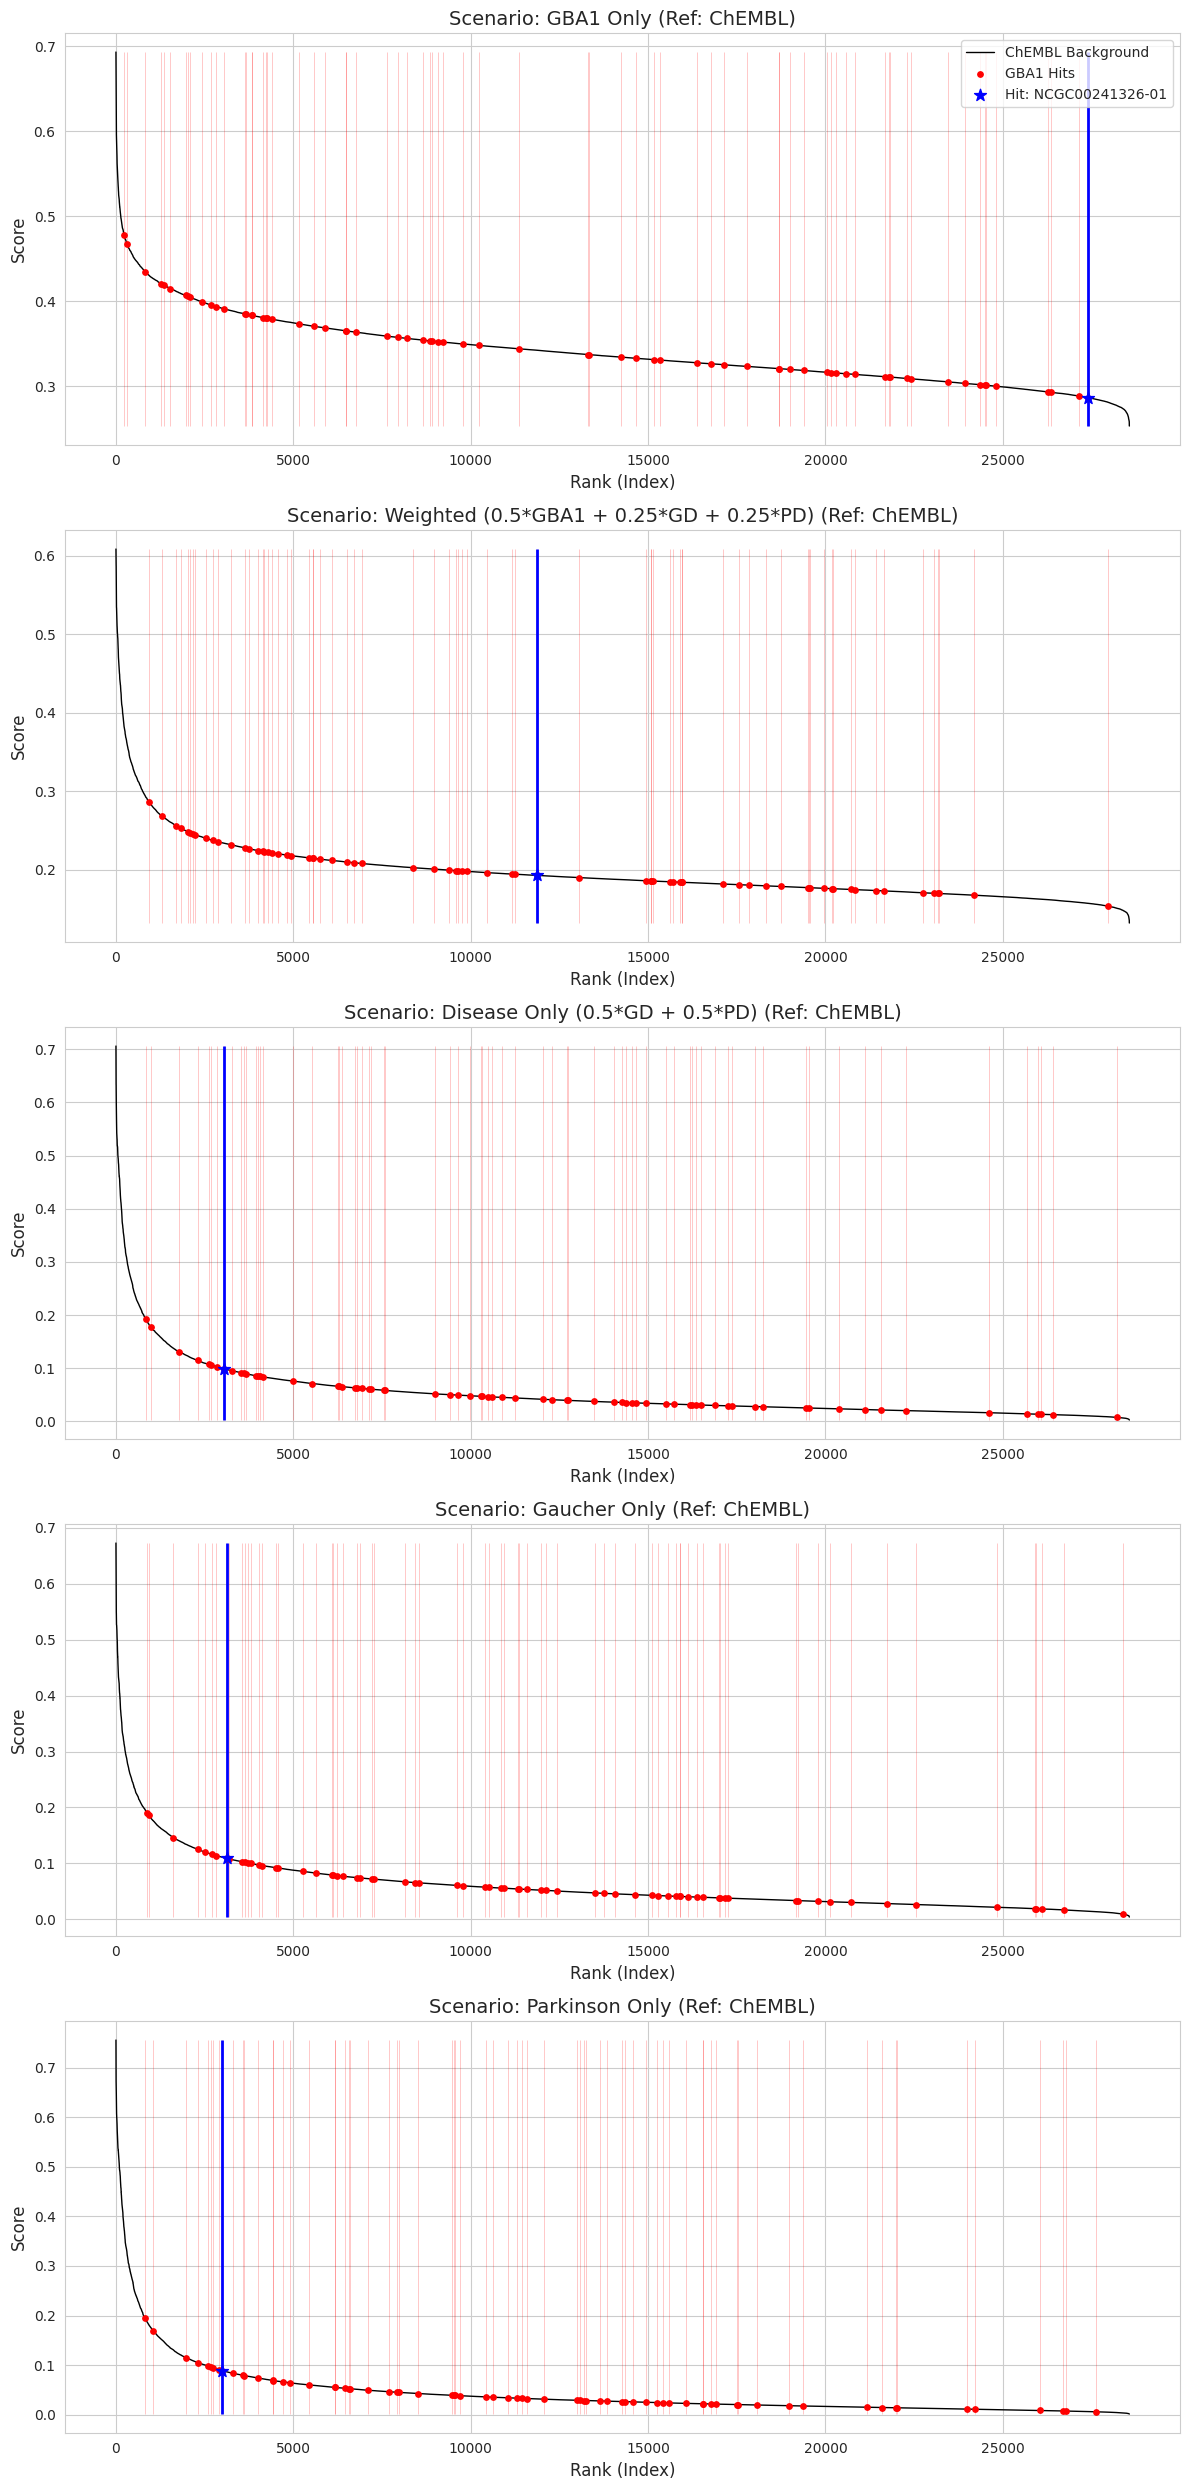

In [18]:
# 4. Visualization: Hits vs ChEMBL Background

gd_score_m = disease_scores_merged.get("Gaucher disease", np.zeros_like(scores_gba1_merged))
pd_score_m = disease_scores_merged.get("Parkinson disease", np.zeros_like(scores_gba1_merged))

scenarios_merged = {
    "GBA1 Only": scores_gba1_merged,
    "Weighted (0.5*GBA1 + 0.25*GD + 0.25*PD)": 0.5 * scores_gba1_merged + 0.25 * gd_score_m + 0.25 * pd_score_m,
    "Disease Only (0.5*GD + 0.5*PD)": 0.5 * gd_score_m + 0.5 * pd_score_m,
    "Gaucher Only": gd_score_m,
    "Parkinson Only": pd_score_m
}

# Special Highlighting
special_id = "NCGC00241326-01"
special_idx_merged = np.where(merged_ids == special_id)[0]

if len(special_idx_merged) > 0:
    _logger.info(f"Highligting special molecule: {special_id} at index {special_idx_merged[0]}")
    special_idx = special_idx_merged[0]
else:
    _logger.warning(f"Special molecule {special_id} not found in merged list.")
    special_idx = None

fig, axes = plt.subplots(len(scenarios_merged), 1, figsize=(12, 5 * len(scenarios_merged)))
if len(scenarios_merged) == 1: axes = [axes]

for ax, (name, scores) in zip(axes, scenarios_merged.items()):
    # Sort all scores descending
    sorted_indices = np.argsort(-scores)
    sorted_scores = scores[sorted_indices]
    
    # Plot 'Background' (ChEMBL) curve
    # We plot the full curve in black
    ax.plot(np.arange(len(sorted_scores)), sorted_scores, color='black', linewidth=1, label='ChEMBL Background')
    
    # Highlight Hits
    # hit_indices_merged are relative to the merged array (0 to N)
    # We need to find where these indices ended up in the sorted list
    is_hit_sorted = np.isin(sorted_indices, hit_indices_merged)
    hit_ranks = np.where(is_hit_sorted)[0]
    hit_scores_sorted = sorted_scores[is_hit_sorted]
    
    # Add markers for general hits
    ax.vlines(hit_ranks, ymin=min(sorted_scores), ymax=max(sorted_scores), color='red', alpha=0.3, linewidth=0.5)
    ax.scatter(hit_ranks, hit_scores_sorted, color='red', s=15, zorder=3, label='GBA1 Hits' if ax == axes[0] else "")
    
    # Highlight Special Molecule
    if special_idx is not None:
        # Find where the special molecule is in the sorted list
        rank_pos = np.where(sorted_indices == special_idx)[0]
        if len(rank_pos) > 0:
            s_rank = rank_pos[0]
            s_score = scores[special_idx]
            
            ax.vlines(s_rank, ymin=min(sorted_scores), ymax=max(sorted_scores), color='blue', alpha=1.0, linewidth=2.0)
            ax.scatter(s_rank, s_score, color='blue', s=80, marker='*', zorder=4, label=f"Hit: {special_id}" if ax == axes[0] else "")
            _logger.info(f"{name}: Special {special_id} Rank = {s_rank}/{len(scores)}")

    # Formatting
    ax.set_title(f"Scenario: {name} (Ref: ChEMBL)", fontsize=14)
    ax.set_xlabel("Rank (Index)", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    
    # Stats
    median_rank = np.median(hit_ranks)
    median_norm_rank = median_rank / len(scores) * 100
    _logger.info(f"{name}: Median Hit Rank = {median_rank:.0f}/{len(scores)} (Top {median_norm_rank:.2f}%)")
    
    if ax == axes[0]: ax.legend()

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "data/notebooks/molecular_analysis/gba1_vs_chembl_rank_curves.png")
plt.show()

[02/04/26 23:04:58] INFO     Computing Recall @ K for ChEMBL Scenarios...                           ]8;id=704605;file:///tmp/ipykernel_616431/3158193049.py\3158193049.py]8;;\:]8;id=323982;file:///tmp/ipykernel_616431/3158193049.py#2\2]8;;\

                    INFO     Saved Recall@K plot to                                                ]8;id=243848;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=467328;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_chembl_gba1_only.png                                     

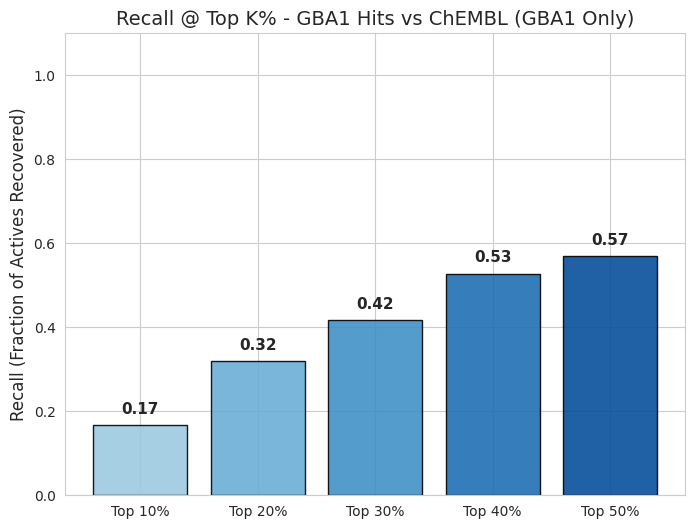

Recall Table: GBA1 Only


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,2856,12,72,0.166667
1,20,5713,23,72,0.319444
2,30,8570,30,72,0.416667
3,40,11426,38,72,0.527778
4,50,14283,41,72,0.569444


                    INFO     Saved Recall@K plot to                                                ]8;id=812798;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=758715;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_chembl_weighted_0.5xgba1_+_0.25xgd_+_0.2                 
                             5xpd.png                                                                              

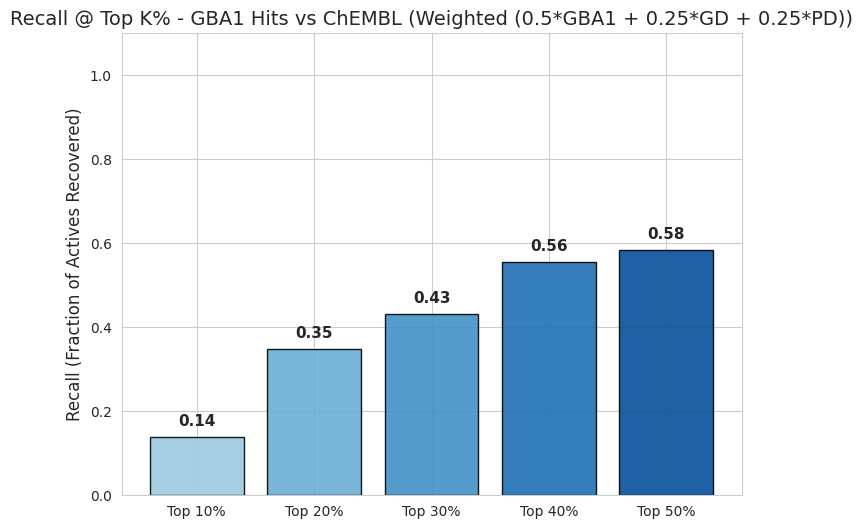

Recall Table: Weighted (0.5*GBA1 + 0.25*GD + 0.25*PD)


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,2856,10,72,0.138889
1,20,5713,25,72,0.347222
2,30,8570,31,72,0.430556
3,40,11426,40,72,0.555556
4,50,14283,42,72,0.583333


                    INFO     Saved Recall@K plot to                                                ]8;id=620821;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=408111;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_chembl_disease_only_0.5xgd_+_0.5xpd.png                  

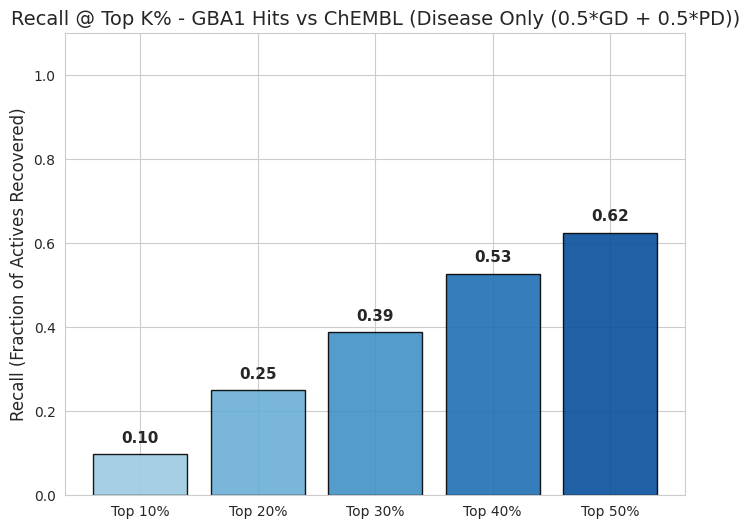

Recall Table: Disease Only (0.5*GD + 0.5*PD)


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,2856,7,72,0.097222
1,20,5713,18,72,0.250000
2,30,8570,28,72,0.388889
3,40,11426,38,72,0.527778
4,50,14283,45,72,0.625000


                    INFO     Saved Recall@K plot to                                                ]8;id=654814;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=472337;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_chembl_gaucher_only.png                                  

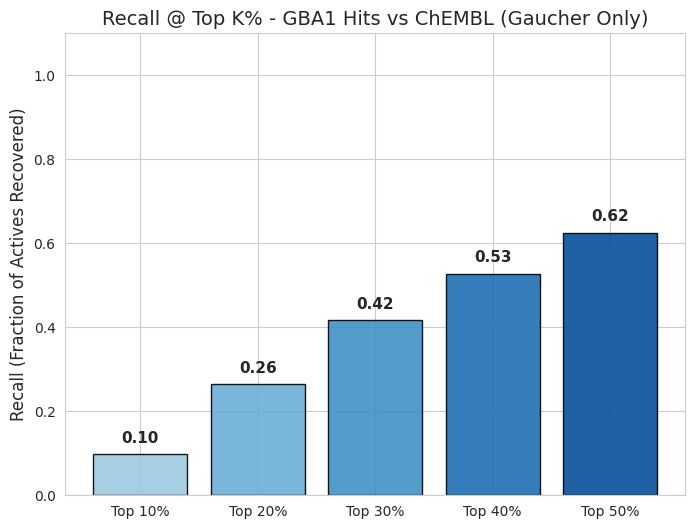

Recall Table: Gaucher Only


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,2856,7,72,0.097222
1,20,5713,19,72,0.263889
2,30,8570,30,72,0.416667
3,40,11426,38,72,0.527778
4,50,14283,45,72,0.625000


[02/04/26 23:04:59] INFO     Saved Recall@K plot to                                                ]8;id=250178;file:///tmp/ipykernel_616431/2113269790.py\2113269790.py]8;;\:]8;id=332518;file:///tmp/ipykernel_616431/2113269790.py#94\94]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mo                 
                             lecular_analysis/recall_at_k_chembl_parkinson_only.png                                

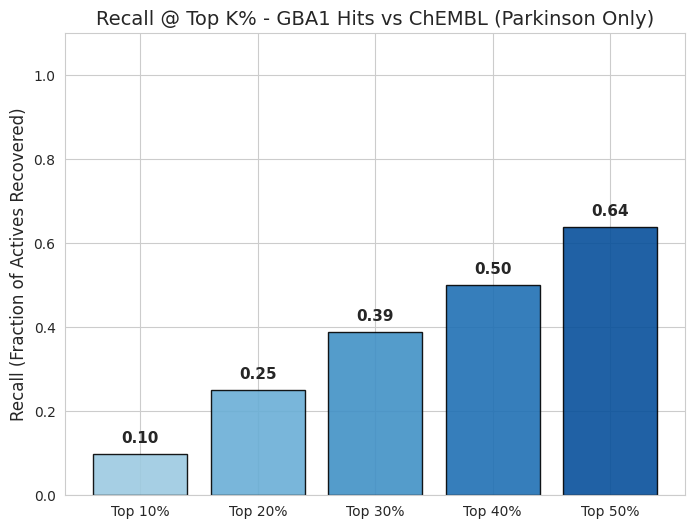

Recall Table: Parkinson Only


,Top K%,Cutoff (N),Recovered,Total Actives,Recall
0,10,2856,7,72,0.097222
1,20,5713,18,72,0.250000
2,30,8570,28,72,0.388889
3,40,11426,36,72,0.500000
4,50,14283,46,72,0.638889


In [19]:
# --- Recall @ K for ChEMBL Scenarios ---
_logger.info("Computing Recall @ K for ChEMBL Scenarios...")

# We iterate through the scenarios again to compute recall
# Actives are 'hit_indices_merged' which are indices in the 'merged' arrays

k_values_chembl = [10, 20, 30, 40, 50]

for name, scores in scenarios_merged.items():
    suffix = f"chembl_{_safe_suffix(name)}"
    
    # We use the same plot_recall_at_k function defined above
    # Note: hit_indices_merged are the indices of actives in the 'scores' array
    
    plot_recall_at_k(
        scores=scores,
        active_indices=hit_indices_merged,
        title=f"GBA1 Hits vs ChEMBL ({name})",
        filename_suffix=suffix,
        k_values=k_values_chembl
    )
    
    print(f"Recall Table: {name}")
    display(recall_at_k_table(scores, hit_indices_merged, k_values=k_values_chembl))

# Fingerprint Similarity: GBA1 Hits vs Huntington Actives vs NeuroKG Drugs

This section computes RDKit Morgan fingerprints for three molecule groups and then quantifies how much the groups overlap using complementary **Tanimoto similarity** aggregates (rather than a single number).

We report for **A vs C** and **B vs C**:
1. Mean + median pairwise Tanimoto similarities.
2. Percentiles (25th, 75th, 90th).
3. Min + max (min is noisy; don’t over-interpret).
4. Fractions above thresholds (e.g. $\ge 0.3, \ge 0.5, \ge 0.7$).
5. Nearest-neighbour coverage: for each molecule in **C**, compute its max similarity to any molecule in **A** (and separately **B**), then summarize that distribution.

**Classes**
- **A**: GBA1 hits
- **B**: Huntington actives
- **C**: NeuroKG drugs


In [20]:
# --- Load SMILES for 3 groups (and remove overlaps vs NeuroKG drugs) ---
from pathlib import Path
from rdkit import Chem

gba1_hits_path = PROJECT_ROOT / "data/neurokg/drugs/GBA1_hits_with_embeddings.csv"
huntington_path = PROJECT_ROOT / "data/neurokg/drugs/huntington_candidates.csv"
neurokg_drugs_path = PROJECT_ROOT / "data/neurokg/drugs/drug_smiles.csv"

for p in [gba1_hits_path, huntington_path, neurokg_drugs_path]:
    if not Path(p).exists():
        raise FileNotFoundError(f"Missing required file: {p}")

# Safe mol parsing + InChIKey helper (mirrors earlier overlap-filtering logic)
def mol_from_smiles_safe(smi):
    try:
        m = Chem.MolFromSmiles(smi)
        if m is None:
            return None
        Chem.SanitizeMol(m, catchErrors=True)
        return m
    except Exception:
        return None

def get_inchi_key(smiles):
    if not isinstance(smiles, str):
        return None
    mol = mol_from_smiles_safe(smiles)
    if mol is None:
        return None
    try:
        return Chem.MolToInchiKey(mol)
    except Exception:
        return None

def _dedupe_preserve_order(items: list[str]) -> list[str]:
    seen = set()
    out = []
    for x in items:
        if x in seen:
            continue
        seen.add(x)
        out.append(x)
    return out

def _clean_smiles_list(series: pd.Series) -> list[str]:
    return (
        series.astype(str)
        .str.strip()
        .replace({"": np.nan, "nan": np.nan, "None": np.nan})
        .dropna()
        .tolist()
    )

# 1) NeuroKG drugs (reference set for overlap removal)
neuro_df = pd.read_csv(neurokg_drugs_path)
neuro_smiles_col = "SMILES" if "SMILES" in neuro_df.columns else ("smiles" if "smiles" in neuro_df.columns else None)
if neuro_smiles_col is None:
    raise ValueError(f"Could not find smiles column in {neurokg_drugs_path}. Columns: {list(neuro_df.columns)}")

neuro_smiles = _dedupe_preserve_order(_clean_smiles_list(neuro_df[neuro_smiles_col]))
_logger.info(f"NeuroKG drugs: loaded {len(neuro_smiles)} SMILES (deduped)")

_logger.info(f"Generating InChIKeys for {len(neuro_smiles)} NeuroKG drugs...")
neuro_inchi = [get_inchi_key(s) for s in neuro_smiles]
existing_keys = set([k for k in neuro_inchi if k is not None])
_logger.info(f"NeuroKG drugs: {len(existing_keys)} non-null InChIKeys")

# 2) GBA1 hits (remove overlaps vs NeuroKG by InChIKey)
gba1_df = pd.read_csv(gba1_hits_path)
gba1_smiles_col = "SMILES" if "SMILES" in gba1_df.columns else ("smiles" if "smiles" in gba1_df.columns else None)
if gba1_smiles_col is None:
    raise ValueError(f"Could not find smiles column in {gba1_hits_path}. Columns: {list(gba1_df.columns)}")

gba1_smiles_raw = _dedupe_preserve_order(_clean_smiles_list(gba1_df[gba1_smiles_col]))
_logger.info(f"GBA1 hits: loaded {len(gba1_smiles_raw)} SMILES (deduped)")

excluded_gba1 = 0
gba1_smiles = []
for s in gba1_smiles_raw:
    key = get_inchi_key(s)
    if key and key in existing_keys:
        excluded_gba1 += 1
        continue
    gba1_smiles.append(s)
_logger.info(f"GBA1 hits: excluded {excluded_gba1} overlaps vs NeuroKG drugs")
_logger.info(f"GBA1 hits: retaining {len(gba1_smiles)} after overlap removal")

# 3) Huntington candidates (filter active; then remove overlaps vs NeuroKG by InChIKey)
hd_df = pd.read_csv(huntington_path)
hd_smiles_col = "smiles" if "smiles" in hd_df.columns else ("SMILES" if "SMILES" in hd_df.columns else None)
if hd_smiles_col is None:
    raise ValueError(f"Could not find smiles column in {huntington_path}. Columns: {list(hd_df.columns)}")

outcome_col = None
for c in hd_df.columns:
    if c.strip().lower() == "pubchem_activity_outcome":
        outcome_col = c
        break
if outcome_col is None:
    raise ValueError(f"Could not find pubchem_Activity_outcome column in {huntington_path}. Columns: {list(hd_df.columns)}")

hd_active_df = hd_df[hd_df[outcome_col].astype(str).str.strip().str.lower() == "active"].copy()
hd_smiles_raw = _dedupe_preserve_order(_clean_smiles_list(hd_active_df[hd_smiles_col]))
_logger.info(f"Huntington actives: loaded {len(hd_smiles_raw)} SMILES (deduped)")

excluded_hd = 0
hd_smiles = []
for s in hd_smiles_raw:
    key = get_inchi_key(s)
    if key and key in existing_keys:
        excluded_hd += 1
        continue
    hd_smiles.append(s)
_logger.info(f"Huntington actives: excluded {excluded_hd} overlaps vs NeuroKG drugs")
_logger.info(f"Huntington actives: retaining {len(hd_smiles)} after overlap removal")

_logger.info(
    "Final SMILES counts used for fingerprinting: "
    f"GBA1 hits={len(gba1_smiles)}, Huntington actives={len(hd_smiles)}, NeuroKG drugs={len(neuro_smiles)}"
 )

[02/04/26 23:19:48] INFO     NeuroKG drugs: loaded 6942 SMILES (deduped)                           ]8;id=407528;file:///tmp/ipykernel_616431/2176028826.py\2176028826.py]8;;\:]8;id=927973;file:///tmp/ipykernel_616431/2176028826.py#61\61]8;;\

[02/04/26 23:19:49] INFO     Generating InChIKeys for 6942 NeuroKG drugs...                        ]8;id=822440;file:///tmp/ipykernel_616431/2176028826.py\2176028826.py]8;;\:]8;id=830452;file:///tmp/ipykernel_616431/2176028826.py#63\63]8;;\

[23:19:51] Explicit valence for atom # 7 Cl, 5, is greater than permitted


[02/04/26 23:19:54] INFO     NeuroKG drugs: 6941 non-null InChIKeys                                ]8;id=298719;file:///tmp/ipykernel_616431/2176028826.py\2176028826.py]8;;\:]8;id=526584;file:///tmp/ipykernel_616431/2176028826.py#66\66]8;;\

                    INFO     GBA1 hits: loaded 84 SMILES (deduped)                                 ]8;id=838540;file:///tmp/ipykernel_616431/2176028826.py\2176028826.py]8;;\:]8;id=862811;file:///tmp/ipykernel_616431/2176028826.py#75\75]8;;\

                    INFO     GBA1 hits: excluded 12 overlaps vs NeuroKG drugs                      ]8;id=480207;file:///tmp/ipykernel_616431/2176028826.py\2176028826.py]8;;\:]8;id=457040;file:///tmp/ipykernel_616431/2176028826.py#85\85]8;;\

                    INFO     GBA1 hits: retaining 72 after overlap removal                         ]8;id=181186;file:///tmp/ipykernel_616431/2176028826.py\2176028826.py]8;;\:]8;id=484651;file:///tmp/ipykernel_616431/2176028826.py#86\86]8;;\

                    INFO     Huntington actives: loaded 55 SMILES (deduped)                       ]8;id=713000;file:///tmp/ipykernel_616431/2176028826.py\2176028826.py]8;;\:]8;id=376798;file:///tmp/ipykernel_616431/2176028826.py#104\104]8;;\

                    INFO     Huntington actives: excluded 0 overlaps vs NeuroKG drugs             ]8;id=623614;file:///tmp/ipykernel_616431/2176028826.py\2176028826.py]8;;\:]8;id=375606;file:///tmp/ipykernel_616431/2176028826.py#114\114]8;;\

                    INFO     Huntington actives: retaining 55 after overlap removal               ]8;id=886405;file:///tmp/ipykernel_616431/2176028826.py\2176028826.py]8;;\:]8;id=649560;file:///tmp/ipykernel_616431/2176028826.py#115\115]8;;\

                    INFO     Final SMILES counts used for fingerprinting: GBA1 hits=72,           ]8;id=11707;file:///tmp/ipykernel_616431/2176028826.py\2176028826.py]8;;\:]8;id=26429;file:///tmp/ipykernel_616431/2176028826.py#117\117]8;;\
                             Huntington actives=55, NeuroKG drugs=6942                                             

[02/04/26 23:39:56] INFO     A = GBA1 hits: 72 valid SMILES, 0 invalid                             ]8;id=815647;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=402553;file:///tmp/ipykernel_616431/1178312166.py#54\54]8;;\

                    INFO     B = Huntington actives: 55 valid SMILES, 0 invalid                    ]8;id=451757;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=505794;file:///tmp/ipykernel_616431/1178312166.py#54\54]8;;\

[23:39:57] Explicit valence for atom # 7 Cl, 5, is greater than permitted


[02/04/26 23:39:57] INFO     C = NeuroKG drugs: 6941 valid SMILES, 1 invalid                       ]8;id=875700;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=24998;file:///tmp/ipykernel_616431/1178312166.py#54\54]8;;\

                    INFO     Computing all pairwise Tanimoto for A vs C: |L|=72, |R|=6941,         ]8;id=443442;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=780001;file:///tmp/ipykernel_616431/1178312166.py#88\88]8;;\
                             pairs=499,752                                                                         

                    INFO     Computing all pairwise Tanimoto for B vs C: |L|=55, |R|=6941,         ]8;id=487768;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=756340;file:///tmp/ipykernel_616431/1178312166.py#88\88]8;;\
                             pairs=381,755                                                                         

,A_vs_C_n,A_vs_C_mean,A_vs_C_median,A_vs_C_p25,A_vs_C_p75,A_vs_C_p90,A_vs_C_min,A_vs_C_max,A_vs_C_frac>= 0.3,A_vs_C_frac>= 0.5,...,B_vs_C_mean,B_vs_C_median,B_vs_C_p25,B_vs_C_p75,B_vs_C_p90,B_vs_C_min,B_vs_C_max,B_vs_C_frac>= 0.3,B_vs_C_frac>= 0.5,B_vs_C_frac>= 0.7
0,499752,0.162007,0.161905,0.125,0.2,0.234043,0.0,1.0,0.010743,0.000238,...,0.167274,0.168831,0.129032,0.206897,0.241379,0.0,0.962963,0.012859,0.000052,0.000008


                    INFO     Computing exact within-group Tanimoto for A vs A: n=72, pairs=2,556  ]8;id=931970;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=951427;file:///tmp/ipykernel_616431/1178312166.py#106\106]8;;\

                    INFO     Computing exact within-group Tanimoto for B vs B: n=55, pairs=1,485  ]8;id=62844;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=177349;file:///tmp/ipykernel_616431/1178312166.py#106\106]8;;\

                    INFO     Within-group C vs C has 24,085,270 pairs; sampling 300,000 pairs     ]8;id=804218;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=499002;file:///tmp/ipykernel_616431/1178312166.py#113\113]8;;\
                             (seed=42)                                                                             

,A_vs_A_n,A_vs_A_mean,A_vs_A_median,A_vs_A_p25,A_vs_A_p75,A_vs_A_p90,A_vs_A_min,A_vs_A_max,A_vs_A_frac>= 0.3,A_vs_A_frac>= 0.5,...,C_vs_C_mean,C_vs_C_median,C_vs_C_p25,C_vs_C_p75,C_vs_C_p90,C_vs_C_min,C_vs_C_max,C_vs_C_frac>= 0.3,C_vs_C_frac>= 0.5,C_vs_C_frac>= 0.7
0,2556,0.202264,0.18,0.146667,0.222222,0.269447,0.04878,0.934426,0.067293,0.039515,...,0.148207,0.148649,0.107143,0.188679,0.225806,0.0,1.0,0.01085,0.000703,0.00013


[02/04/26 23:39:58] INFO     Computing NN coverage for C max-to-A: ref=72 vs C=6941               ]8;id=756277;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=976096;file:///tmp/ipykernel_616431/1178312166.py#196\196]8;;\

                    INFO     Computing NN coverage for C max-to-B: ref=55 vs C=6941               ]8;id=771802;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=927343;file:///tmp/ipykernel_616431/1178312166.py#196\196]8;;\

,C_max_to_A_n,C_max_to_A_mean,C_max_to_A_median,C_max_to_A_p25,C_max_to_A_p75,C_max_to_A_p90,C_max_to_A_min,C_max_to_A_max,C_max_to_A_frac>= 0.3,C_max_to_A_frac>= 0.5,...,C_max_to_B_mean,C_max_to_B_median,C_max_to_B_p25,C_max_to_B_p75,C_max_to_B_p90,C_max_to_B_min,C_max_to_B_max,C_max_to_B_frac>= 0.3,C_max_to_B_frac>= 0.5,C_max_to_B_frac>= 0.7
0,6941,0.279757,0.28125,0.244898,0.314286,0.35,0.020833,1.0,0.357297,0.009653,...,0.266448,0.271605,0.229885,0.307692,0.33945,0.0,0.962963,0.303414,0.002881,0.000432


                    INFO     Computing exact within-group max similarity for A max-to-A (exclude  ]8;id=342149;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=988242;file:///tmp/ipykernel_616431/1178312166.py#146\146]8;;\
                             self): n=72                                                                           

                    INFO     Approximating within-group max similarity for C max-to-C (exclude    ]8;id=878044;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=143482;file:///tmp/ipykernel_616431/1178312166.py#152\152]8;;\
                             self): n=6941, sample_k=2048, seed=42                                                 

[02/04/26 23:40:00] INFO     Computing exact within-group max similarity for B max-to-B (exclude  ]8;id=155552;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=78094;file:///tmp/ipykernel_616431/1178312166.py#146\146]8;;\
                             self): n=55                                                                           

,A_max_to_A_n,A_max_to_A_mean,A_max_to_A_median,A_max_to_A_p25,A_max_to_A_p75,A_max_to_A_p90,A_max_to_A_min,A_max_to_A_max,A_max_to_A_frac>= 0.3,A_max_to_A_frac>= 0.5,...,B_max_to_B_mean,B_max_to_B_median,B_max_to_B_p25,B_max_to_B_p75,B_max_to_B_p90,B_max_to_B_min,B_max_to_B_max,B_max_to_B_frac>= 0.3,B_max_to_B_frac>= 0.5,B_max_to_B_frac>= 0.7
0,72,0.492105,0.389702,0.301378,0.696314,0.758974,0.21519,0.934426,0.75,0.444444,...,0.414704,0.358974,0.32192,0.458827,0.622951,0.206349,0.816327,0.818182,0.218182,0.054545


[02/04/26 23:40:01] INFO     Saved                                                                ]8;id=586115;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=86137;file:///tmp/ipykernel_616431/1178312166.py#242\242]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/m                  
                             olecular_analysis/tanimoto_pairwise_hist_A_B_vs_C.png                                 

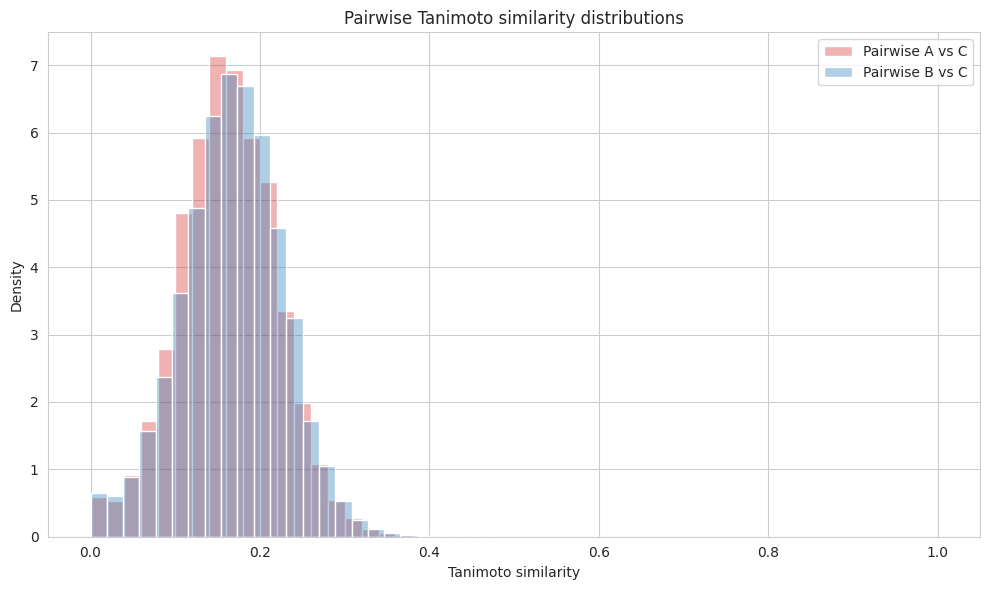

                    INFO     Saved                                                                ]8;id=779538;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=328261;file:///tmp/ipykernel_616431/1178312166.py#260\260]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/m                  
                             olecular_analysis/tanimoto_within_group_hist_A_B_C.png                                

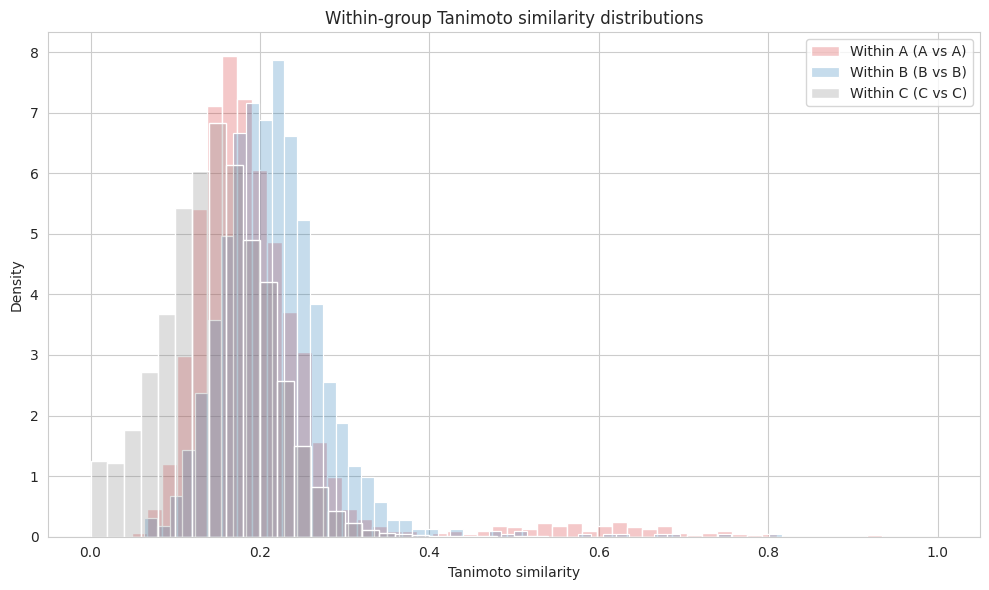

[02/04/26 23:40:02] INFO     Saved                                                                ]8;id=633378;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=349622;file:///tmp/ipykernel_616431/1178312166.py#285\285]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/m                  
                             olecular_analysis/tanimoto_max_similarity_hist_between_within.png                     

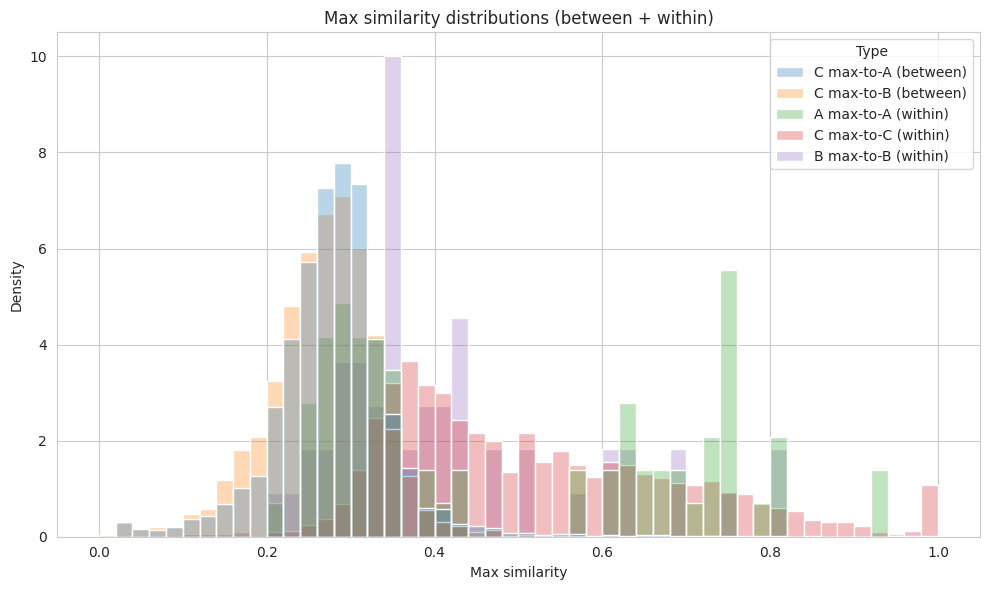

                    INFO     Saved                                                                ]8;id=915970;file:///tmp/ipykernel_616431/1178312166.py\1178312166.py]8;;\:]8;id=292072;file:///tmp/ipykernel_616431/1178312166.py#296\296]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/m                  
                             olecular_analysis/tanimoto_max_similarity_boxplots_between_within.pn                  
                             g                                                                                     

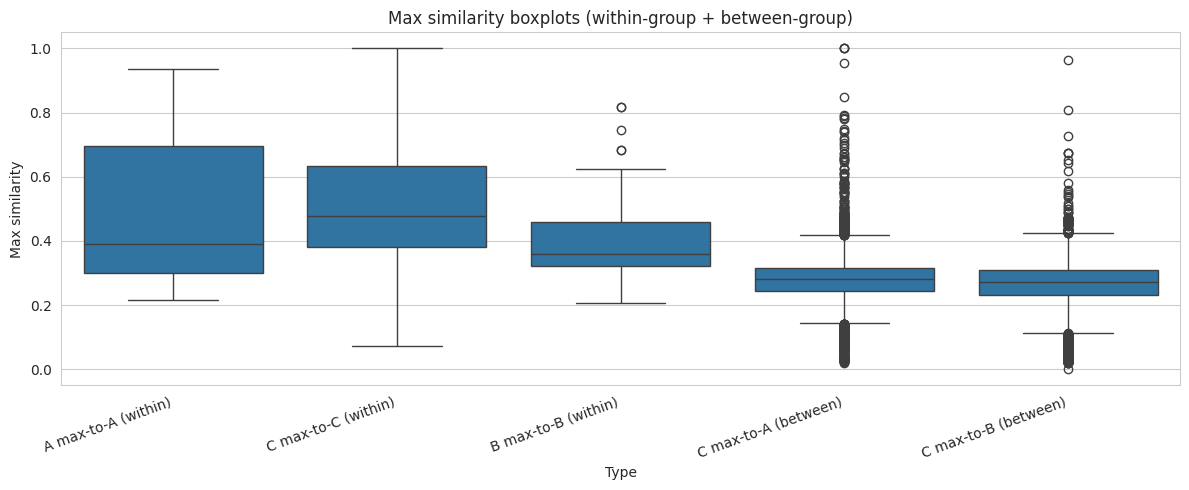

Notes:
- Between-group aggregates (A vs C, B vs C) reflect overall similarity between sets.
- Within-group aggregates (A vs A, B vs B, C vs C) describe internal diversity of each set.
- Max-similarity within-group (A max-to-A, C max-to-C, B max-to-B) indicates redundancy / tight clusters inside a set.
- NN coverage (C max-to-A / max-to-B) answers: for each NeuroKG drug, is there a similar molecule in A/B?
- Fractions >= thresholds are often the most actionable overlap signal.


In [26]:
# --- RDKit fingerprints (Morgan generator, 256 bits) + Tanimoto similarity aggregates ---
import math
from rdkit import Chem, DataStructs
from rdkit.Chem import rdFingerprintGenerator

# -----------------------
# Safe mol + Morgan generator fingerprint helpers (requested)
FP_RADIUS = 2
FP_NBITS = 256
NBINS = 50

def mol_from_smiles_safe(smi):
    try:
        m = Chem.MolFromSmiles(smi)
        if m is None:
            return None
        Chem.SanitizeMol(m, catchErrors=True)
        return m
    except Exception:
        return None

# Use RDKit Morgan generator (no deprecation warnings)
_morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=FP_RADIUS, fpSize=FP_NBITS)
def fp_from_mol(mol):
    return _morgan_gen.GetFingerprint(mol)

def tanimoto(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def sim_to_bin(sim, nbins=NBINS):
    b = int(math.floor(sim * nbins))
    if b >= nbins:
        b = nbins - 1
    if b < 0:
        b = 0
    return b

def build_group_fps(smiles_list: list[str], group_name: str):
    good_smiles = []
    fps = []
    bad = 0
    for s in smiles_list:
        mol = mol_from_smiles_safe(s)
        if mol is None:
            bad += 1
            continue
        try:
            fp = fp_from_mol(mol)
        except Exception:
            bad += 1
            continue
        good_smiles.append(s)
        fps.append(fp)
    _logger.info(f"{group_name}: {len(good_smiles)} valid SMILES, {bad} invalid")
    return good_smiles, fps

# 1) Compute fingerprints (on overlap-filtered SMILES lists from previous cell)
A_smiles_ok, A_fps = build_group_fps(gba1_smiles, "A = GBA1 hits")
B_smiles_ok, B_fps = build_group_fps(hd_smiles, "B = Huntington actives")
C_smiles_ok, C_fps = build_group_fps(neuro_smiles, "C = NeuroKG drugs")

if len(A_fps) == 0 or len(C_fps) == 0:
    raise ValueError(f"Need non-empty A and C fingerprint sets. Got |A|={len(A_fps)} |C|={len(C_fps)}")

THRESHOLDS = [0.3, 0.5, 0.7]

def summarize_similarity_array(sims: np.ndarray, thresholds=THRESHOLDS, prefix: str = "") -> dict:
    sims = np.asarray(sims, dtype=np.float32)
    out = {
        f"{prefix}n": int(sims.size),
        f"{prefix}mean": float(np.mean(sims)) if sims.size else np.nan,
        f"{prefix}median": float(np.median(sims)) if sims.size else np.nan,
        f"{prefix}p25": float(np.percentile(sims, 25)) if sims.size else np.nan,
        f"{prefix}p75": float(np.percentile(sims, 75)) if sims.size else np.nan,
        f"{prefix}p90": float(np.percentile(sims, 90)) if sims.size else np.nan,
        f"{prefix}min": float(np.min(sims)) if sims.size else np.nan,
        f"{prefix}max": float(np.max(sims)) if sims.size else np.nan,
    }
    for t in thresholds:
        out[f"{prefix}frac>= {t}"] = float(np.mean(sims >= t)) if sims.size else np.nan
    return out

def all_pairwise_tanimoto(fps_left: list, fps_right: list, desc: str):
    # Computes all pairwise similarities (|L|*|R|) using BulkTanimotoSimilarity.
    # Returns a flat np.ndarray of similarities.
    nL, nR = len(fps_left), len(fps_right)
    total = nL * nR
    _logger.info(f"Computing all pairwise Tanimoto for {desc}: |L|={nL}, |R|={nR}, pairs={total:,}")
    sims_all = np.empty((total,), dtype=np.float32)
    offset = 0
    for fpL in fps_left:
        sims = DataStructs.BulkTanimotoSimilarity(fpL, fps_right)
        sims = np.asarray(sims, dtype=np.float32)
        sims_all[offset : offset + nR] = sims
        offset += nR
    return sims_all

def within_group_pairwise_tanimoto(fps: list, desc: str, max_pairs_exact: int = 2_000_000, sample_pairs: int = 300_000, seed: int = 42) -> np.ndarray:
    # Computes similarities for all unordered pairs i<j within a group.
    # If the number of pairs is large, randomly samples pairs to keep runtime/memory bounded.
    n = len(fps)
    if n < 2:
        return np.array([], dtype=np.float32)
    total_pairs = n * (n - 1) // 2
    if total_pairs <= max_pairs_exact:
        _logger.info(f"Computing exact within-group Tanimoto for {desc}: n={n}, pairs={total_pairs:,}")
        sims_chunks = []
        for i in range(n - 1):
            sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[i + 1 :])
            sims_chunks.append(np.asarray(sims, dtype=np.float32))
        return np.concatenate(sims_chunks) if sims_chunks else np.array([], dtype=np.float32)
    else:
        _logger.info(
            f"Within-group {desc} has {total_pairs:,} pairs; sampling {sample_pairs:,} pairs (seed={seed})"
        )
        rng = np.random.default_rng(seed)
        sims = np.empty((sample_pairs,), dtype=np.float32)
        filled = 0
        while filled < sample_pairs:
            batch = min(200_000, (sample_pairs - filled) * 3)
            i = rng.integers(0, n, size=batch)
            j = rng.integers(0, n, size=batch)
            m = i != j
            i = i[m]
            j = j[m]
            lo = np.minimum(i, j)
            hi = np.maximum(i, j)
            need = sample_pairs - filled
            take = min(need, lo.size)
            lo = lo[:take]
            hi = hi[:take]
            for k in range(take):
                sims[filled + k] = tanimoto(fps[int(lo[k])], fps[int(hi[k])])
            filled += take
        return sims

def within_group_max_similarity(fps: list, desc: str, max_exact_n: int = 3000, sample_k: int = 2048, seed: int = 42) -> np.ndarray:
    """For each molecule i, compute max Tanimoto to any other molecule in the same set (excluding itself).
    If the set is large, approximate by comparing to a random subset of other molecules per i."""
    n = len(fps)
    if n < 2:
        return np.array([], dtype=np.float32)
    rng = np.random.default_rng(seed)
    max_sims = np.zeros((n,), dtype=np.float32)
    if n <= max_exact_n:
        _logger.info(f"Computing exact within-group max similarity for {desc}: n={n}")
        for i in range(n):
            sims = np.asarray(DataStructs.BulkTanimotoSimilarity(fps[i], fps), dtype=np.float32)
            sims[i] = -1.0  # exclude self
            max_sims[i] = float(np.max(sims))
        return max_sims
    _logger.info(f"Approximating within-group max similarity for {desc}: n={n}, sample_k={sample_k}, seed={seed}")
    for i in range(n):
        k = min(sample_k, n - 1)
        idx = rng.choice(n - 1, size=k, replace=False)
        # map [0..n-2] -> [0..n-1] skipping i
        idx = np.where(idx >= i, idx + 1, idx)
        fp_pool = [fps[int(j)] for j in idx]
        sims = np.asarray(DataStructs.BulkTanimotoSimilarity(fps[i], fp_pool), dtype=np.float32)
        max_sims[i] = float(np.max(sims)) if sims.size else 0.0
    return max_sims

# 2) Between-group pairwise summaries (A vs C, B vs C)
sims_A_C = all_pairwise_tanimoto(A_fps, C_fps, "A vs C")
summary_A_C = summarize_similarity_array(sims_A_C, prefix="A_vs_C_")

if len(B_fps) > 0:
    sims_B_C = all_pairwise_tanimoto(B_fps, C_fps, "B vs C")
    summary_B_C = summarize_similarity_array(sims_B_C, prefix="B_vs_C_")
else:
    sims_B_C = np.array([], dtype=np.float32)
    summary_B_C = summarize_similarity_array(sims_B_C, prefix="B_vs_C_")

pairwise_summary_df = pd.DataFrame([{**summary_A_C, **summary_B_C}])
display(pairwise_summary_df)

# 3) Within-group pairwise similarity distributions (A vs A, B vs B, C vs C)
sims_A_A = within_group_pairwise_tanimoto(A_fps, "A vs A")
summary_A_A = summarize_similarity_array(sims_A_A, prefix="A_vs_A_")

sims_B_B = within_group_pairwise_tanimoto(B_fps, "B vs B")
summary_B_B = summarize_similarity_array(sims_B_B, prefix="B_vs_B_")

# C can be large; this will sample if needed
sims_C_C = within_group_pairwise_tanimoto(C_fps, "C vs C")
summary_C_C = summarize_similarity_array(sims_C_C, prefix="C_vs_C_")

within_summary_df = pd.DataFrame([{**summary_A_A, **summary_B_B, **summary_C_C}])
display(within_summary_df)

# 4) Nearest-neighbour coverage (per molecule in C: max similarity to any in A / any in B)
def max_sim_to_reference_set_per_C(ref_fps: list, C_fps: list, desc: str) -> np.ndarray:
    if len(ref_fps) == 0:
        return np.zeros((len(C_fps),), dtype=np.float32)
    max_sims = np.zeros((len(C_fps),), dtype=np.float32)
    _logger.info(f"Computing NN coverage for {desc}: ref={len(ref_fps)} vs C={len(C_fps)}")
    for fp_ref in ref_fps:
        sims = DataStructs.BulkTanimotoSimilarity(fp_ref, C_fps)
        max_sims = np.maximum(max_sims, np.asarray(sims, dtype=np.float32))
    return max_sims

C_max_to_A = max_sim_to_reference_set_per_C(A_fps, C_fps, "C max-to-A")
summary_C_max_to_A = summarize_similarity_array(C_max_to_A, prefix="C_max_to_A_")

C_max_to_B = max_sim_to_reference_set_per_C(B_fps, C_fps, "C max-to-B")
summary_C_max_to_B = summarize_similarity_array(C_max_to_B, prefix="C_max_to_B_")

nn_summary_df = pd.DataFrame([{**summary_C_max_to_A, **summary_C_max_to_B}])
display(nn_summary_df)

# 4b) Within-group max similarity (exclude self): A max-to-A, C max-to-C
A_max_to_A = within_group_max_similarity(A_fps, "A max-to-A (exclude self)")
summary_A_max_to_A = summarize_similarity_array(A_max_to_A, prefix="A_max_to_A_")

C_max_to_C = within_group_max_similarity(C_fps, "C max-to-C (exclude self)")
summary_C_max_to_C = summarize_similarity_array(C_max_to_C, prefix="C_max_to_C_")

B_max_to_B = within_group_max_similarity(B_fps, "B max-to-B (exclude self)")
summary_B_max_to_B = summarize_similarity_array(B_max_to_B, prefix="B_max_to_B_")

within_nn_summary_df = pd.DataFrame([{**summary_A_max_to_A, **summary_C_max_to_C, **summary_B_max_to_B}])
display(within_nn_summary_df)

# 5) Optional visuals: histograms + boxplots
PLOT = True
if PLOT:
    plot_dir = PROJECT_ROOT / "data/notebooks/molecular_analysis"
    plot_dir.mkdir(parents=True, exist_ok=True)

    # Pairwise similarity histograms (density)
    plt.figure(figsize=(10, 6))
    sns.histplot(sims_A_C, bins=NBINS, stat="density", color="#D62728", alpha=0.35, label="Pairwise A vs C")
    if sims_B_C.size > 0:
        sns.histplot(sims_B_C, bins=NBINS, stat="density", color="#1F77B4", alpha=0.35, label="Pairwise B vs C")
    plt.xlabel("Tanimoto similarity")
    plt.ylabel("Density")
    plt.title("Pairwise Tanimoto similarity distributions")
    plt.legend()
    plt.tight_layout()
    out = plot_dir / "tanimoto_pairwise_hist_A_B_vs_C.png"
    plt.savefig(out, dpi=200)
    _logger.info(f"Saved {out}")
    plt.show()

    # Within-group histograms (A vs A, B vs B, C vs C)
    plt.figure(figsize=(10, 6))
    if sims_A_A.size > 0:
        sns.histplot(sims_A_A, bins=NBINS, stat="density", color="#D62728", alpha=0.25, label="Within A (A vs A)")
    if sims_B_B.size > 0:
        sns.histplot(sims_B_B, bins=NBINS, stat="density", color="#1F77B4", alpha=0.25, label="Within B (B vs B)")
    if sims_C_C.size > 0:
        sns.histplot(sims_C_C, bins=NBINS, stat="density", color="#7F7F7F", alpha=0.25, label="Within C (C vs C)")
    plt.xlabel("Tanimoto similarity")
    plt.ylabel("Density")
    plt.title("Within-group Tanimoto similarity distributions")
    plt.legend()
    plt.tight_layout()
    out = plot_dir / "tanimoto_within_group_hist_A_B_C.png"
    plt.savefig(out, dpi=200)
    _logger.info(f"Saved {out}")
    plt.show()

    # Nearest-neighbour max-similarity distributions (between + within)
    nn_df = pd.DataFrame(
        {
            "Max similarity": np.concatenate([C_max_to_A, C_max_to_B, A_max_to_A, C_max_to_C, B_max_to_B]),
            "Type": (
                ["C max-to-A (between)"] * len(C_max_to_A)
                + ["C max-to-B (between)"] * len(C_max_to_B)
                + ["A max-to-A (within)"] * len(A_max_to_A)
                + ["C max-to-C (within)"] * len(C_max_to_C)
                + ["B max-to-B (within)"] * len(B_max_to_B)
            ),
        }
    )

    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=nn_df, x="Max similarity", hue="Type", bins=NBINS, stat="density", common_norm=False, alpha=0.30,
    )
    plt.title("Max similarity distributions (between + within)")
    plt.tight_layout()
    out = plot_dir / "tanimoto_max_similarity_hist_between_within.png"
    plt.savefig(out, dpi=200)
    _logger.info(f"Saved {out}")
    plt.show()

    plt.figure(figsize=(12, 5))
    order = ["A max-to-A (within)", "C max-to-C (within)", "B max-to-B (within)", "C max-to-A (between)", "C max-to-B (between)"]
    sns.boxplot(data=nn_df, x="Type", y="Max similarity", order=order)
    plt.xticks(rotation=20, ha="right")
    plt.title("Max similarity boxplots (within-group + between-group)")
    plt.tight_layout()
    out = plot_dir / "tanimoto_max_similarity_boxplots_between_within.png"
    plt.savefig(out, dpi=200)
    _logger.info(f"Saved {out}")
    plt.show()

print("Notes:")
print("- Between-group aggregates (A vs C, B vs C) reflect overall similarity between sets.")
print("- Within-group aggregates (A vs A, B vs B, C vs C) describe internal diversity of each set.")
print("- Max-similarity within-group (A max-to-A, C max-to-C, B max-to-B) indicates redundancy / tight clusters inside a set.")
print("- NN coverage (C max-to-A / max-to-B) answers: for each NeuroKG drug, is there a similar molecule in A/B?")
print("- Fractions >= thresholds are often the most actionable overlap signal.")